# Skapa 2 modeller per ticker   
1. En modell som använder tomorrows close som target  
2. En modell som använder day after tomorrows close som target   

In [1]:
import sklearn

import xgboost as xgb

import catboost
from catboost import CatBoostClassifier

from pytrends.request import TrendReq
import pytrends
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# plt.style.use('fivethirtyeight')
pd.set_option('display.width', 200)
import plotly.express as px
import streamlit as st
import google

# importera loggin
import logging

# Starta upp logging och inkluder rad nummer
logging.basicConfig(level=logging.DEBUG, filemode='w', filename='krypto.log', force=True,
                    encoding='utf-8', format= '%(asctime)s - %(levelname)s - %(lineno)d - %(message)s')
logging.info('Startar')


In [2]:
print('Versioner av softvara som används i denna notebook:')
# print numpy version
print('numpy=={}'.format(np.__version__))
# print pandas version
print('pandas=={}'.format(pd.__version__))
# print matplotlib version
print('matplotlib=={}'.format(plt.matplotlib.__version__))
# print yfinance version
print('yfinance=={}'.format(yf.__version__))
# print pytreands version
print('pytrends==4.8.0') 
# print python-dateutil version
print('python-dateutil==2.8.2')
# print ta version
print('ta==0.10.2')
# print streamlit version
print('streamlit=={}'.format(st.__version__))
print('xgboost=={}'.format(xgb.__version__))
print('catboost=={}'.format(catboost.__version__))

print('sklearn=={}'.format(sklearn.__version__))
#print google version
print('google-crc32==1.1.2')
# print pandas-ta version
print('pandas-ta==0.3.14b0')
# print plotly version
print('plotly==5.3.1')



Versioner av softvara som används i denna notebook:
numpy==1.23.4
pandas==1.4.4
matplotlib==3.6.2
yfinance==0.1.72
pytrends==4.8.0
python-dateutil==2.8.2
ta==0.10.2
streamlit==1.14.0
xgboost==1.7.1
catboost==1.0.6
sklearn==1.0.2
google-crc32==1.1.2
pandas-ta==0.3.14b0
plotly==5.3.1


# Här följer ChatGPT inspirerad kod för att skapa data från yahoo finance

In [3]:
tickers = ['BTC-USD','ETH-USD','BCH-USD','ZRX-USD','XRP-USD']
ticker_names = ['Bitcoin','Ethereum','Bitcoin Cash','0X','Ripple']

In [4]:
def import_ticker_data(tickers, ticker_names):
    df = yf.download(tickers, interval='1d',
                       group_by='ticker', auto_adjust=True)
    df = pd.DataFrame(df.xs('Close', level=1, axis=1))
    df.columns = ticker_names
    df.dropna(inplace=True)
    
    df = df.assign(**{ticker_name + '_pct_change': df[ticker_name].pct_change()*100 for ticker_name in ticker_names})
    df.fillna(0, inplace=True)
    # df.dropna(inplace=True)
    
    return df

df = import_ticker_data(tickers, ticker_names)
df.tail(10)

[*********************100%***********************]  5 of 5 completed


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_pct_change,Ethereum_pct_change,Bitcoin Cash_pct_change,0X_pct_change,Ripple_pct_change
Date,,,,,,,,,,
2023-02-07,135.969208,1672.003540,0.403904,0.260984,23264.291016,3.317953,3.449749,2.820601,6.658169,2.215199
2023-02-08,131.495438,1650.716797,0.398052,0.254860,22939.398438,-3.290282,-1.273128,-1.448855,-2.346500,-1.396529
2023-02-09,126.427086,1546.438232,0.382466,0.228763,21819.039062,-3.854394,-6.317169,-3.915573,-10.239745,-4.883996
2023-02-10,124.681725,1514.869141,0.382645,0.231988,21651.183594,-1.380528,-2.041407,0.046807,1.409755,-0.769307
2023-02-11,124.764580,1539.926758,0.384008,0.242538,21870.875000,0.066453,1.654111,0.356199,4.547652,1.014685
2023-02-12,122.900429,1515.033691,0.375282,0.233867,21788.203125,-1.494135,-1.616510,-2.272349,-3.575110,-0.378000
2023-02-13,123.858047,1507.165894,0.371675,0.224189,21808.101562,0.779183,-0.519315,-0.961137,-4.138252,0.091327
2023-02-14,126.731865,1556.875122,0.382407,0.232489,22220.804688,2.320251,3.298192,2.887467,3.702236,1.892430
2023-02-15,134.574158,1673.745972,0.401352,0.254230,24307.841797,6.188099,7.506758,4.954140,9.351405,9.392266


In [5]:
def beräkna_rolling_mean(df, ticker_names, window=20):
    rolling_mean=pd.DataFrame()
    for ticker_name in ticker_names:
        df[ticker_name+'-rolling']= df[ticker_name].rolling(window=window).mean()
        
    df.dropna(inplace=True)    
    return df   

def beräkna_cumulative_return(df, ticker_names):
    cumulative_return={}
    for ticker_name in ticker_names:
        cumulative_return[ticker_name] = (df[ticker_name].iloc[-1]/df[ticker_name].iloc[0]-1)
    return cumulative_return

df = beräkna_rolling_mean(df, ticker_names, window=20)
display(df)
display(pd.DataFrame(beräkna_cumulative_return(df.query("Date > '2021-04-13'"), ticker_names), index=['cum_ret']))


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_pct_change,Ethereum_pct_change,Bitcoin Cash_pct_change,0X_pct_change,Ripple_pct_change,Bitcoin-rolling,Ethereum-rolling,Bitcoin Cash-rolling,0X-rolling,Ripple-rolling
Date,,,,,,,,,,,,,,,
2017-11-28,1546.180054,472.902008,0.299152,0.225542,10058.799805,-4.707957,-1.551561,17.810235,-3.249444,2.448988,1313.403958,373.973451,0.231176,0.208566,7840.200977
2017-11-29,1359.709961,427.523010,0.243064,0.190781,9888.610352,-12.060050,-9.595856,-18.748993,-15.412206,-1.691946,1348.674307,379.305402,0.232455,0.206577,7977.452490
2017-11-30,1389.780029,447.114014,0.250878,0.188614,10233.599609,2.211506,4.582444,3.214793,-1.135858,3.488754,1367.792310,386.698453,0.234674,0.206147,8158.225464
2017-12-01,1462.680054,466.540009,0.255699,0.201924,10975.599609,5.245436,4.344752,1.921652,7.056741,7.250626,1373.903815,394.291403,0.236938,0.206385,8389.125439
2017-12-02,1434.979980,463.449005,0.255492,0.211218,11074.599609,-1.893789,-0.662538,-0.080957,4.602724,0.902001,1376.209814,402.068454,0.239846,0.207551,8645.351929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-12,122.900429,1515.033691,0.375282,0.233867,21788.203125,-1.494135,-1.616510,-2.272349,-3.575110,-0.378000,132.211637,1602.287531,0.401822,0.236144,22883.824414
2023-02-13,123.858047,1507.165894,0.371675,0.224189,21808.101562,0.779183,-0.519315,-0.961137,-4.138252,0.091327,131.989727,1599.815613,0.400020,0.236468,22842.406055
2023-02-14,126.731865,1556.875122,0.382407,0.232489,22220.804688,2.320251,3.298192,2.887467,3.702236,1.892430,131.731638,1597.073816,0.398256,0.236827,22797.553320


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple
cum_ret,-0.836966,-0.304394,-0.785508,-0.87837,-0.610737


In [6]:
pct_list=['Bitcoin_pct_change',	'Ethereum_pct_change',	'Bitcoin Cash_pct_change',	'0X_pct_change',	'Ripple_pct_change'	]
df

,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_pct_change,Ethereum_pct_change,Bitcoin Cash_pct_change,0X_pct_change,Ripple_pct_change,Bitcoin-rolling,Ethereum-rolling,Bitcoin Cash-rolling,0X-rolling,Ripple-rolling
Date,,,,,,,,,,,,,,,
2017-11-28,1546.180054,472.902008,0.299152,0.225542,10058.799805,-4.707957,-1.551561,17.810235,-3.249444,2.448988,1313.403958,373.973451,0.231176,0.208566,7840.200977
2017-11-29,1359.709961,427.523010,0.243064,0.190781,9888.610352,-12.060050,-9.595856,-18.748993,-15.412206,-1.691946,1348.674307,379.305402,0.232455,0.206577,7977.452490
2017-11-30,1389.780029,447.114014,0.250878,0.188614,10233.599609,2.211506,4.582444,3.214793,-1.135858,3.488754,1367.792310,386.698453,0.234674,0.206147,8158.225464
2017-12-01,1462.680054,466.540009,0.255699,0.201924,10975.599609,5.245436,4.344752,1.921652,7.056741,7.250626,1373.903815,394.291403,0.236938,0.206385,8389.125439
2017-12-02,1434.979980,463.449005,0.255492,0.211218,11074.599609,-1.893789,-0.662538,-0.080957,4.602724,0.902001,1376.209814,402.068454,0.239846,0.207551,8645.351929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-12,122.900429,1515.033691,0.375282,0.233867,21788.203125,-1.494135,-1.616510,-2.272349,-3.575110,-0.378000,132.211637,1602.287531,0.401822,0.236144,22883.824414
2023-02-13,123.858047,1507.165894,0.371675,0.224189,21808.101562,0.779183,-0.519315,-0.961137,-4.138252,0.091327,131.989727,1599.815613,0.400020,0.236468,22842.406055
2023-02-14,126.731865,1556.875122,0.382407,0.232489,22220.804688,2.320251,3.298192,2.887467,3.702236,1.892430,131.731638,1597.073816,0.398256,0.236827,22797.553320


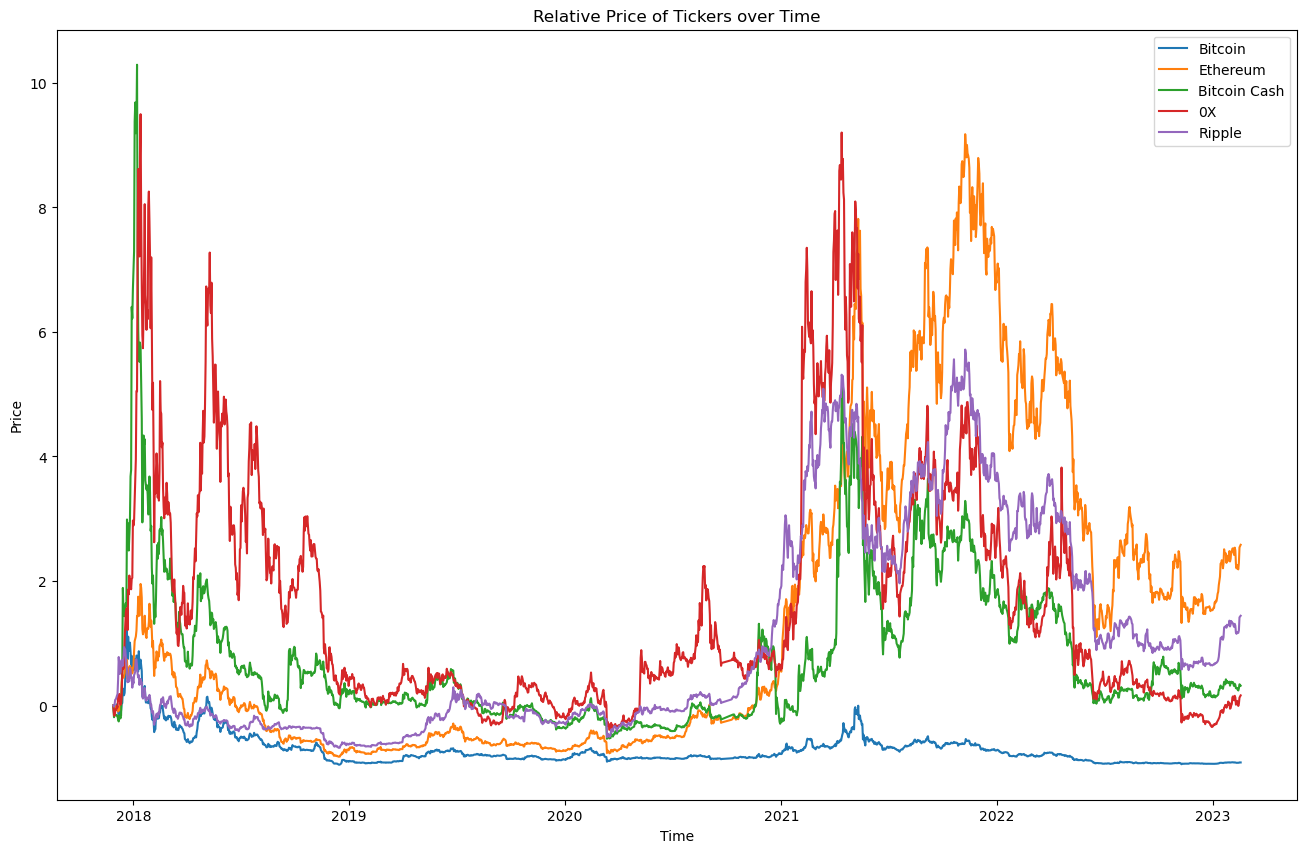

In [7]:
def plot_ticker_data(df, tickers, start=None):
    plt.figure(figsize=(16, 10))
    # df = df.query('index > "2021-04-13"')
    if start is not None:
        df = df.query('index > @start') 
    for ticker in tickers:
        
        data = df[ticker] / df[ticker][0] - 1
        plt.plot(data, label=ticker)
    
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.title('Relative Price of Tickers over Time')
    plt.show()
plot_ticker_data(df, ticker_names)

# Slut på chatGPT




## Get inflation data US and SE

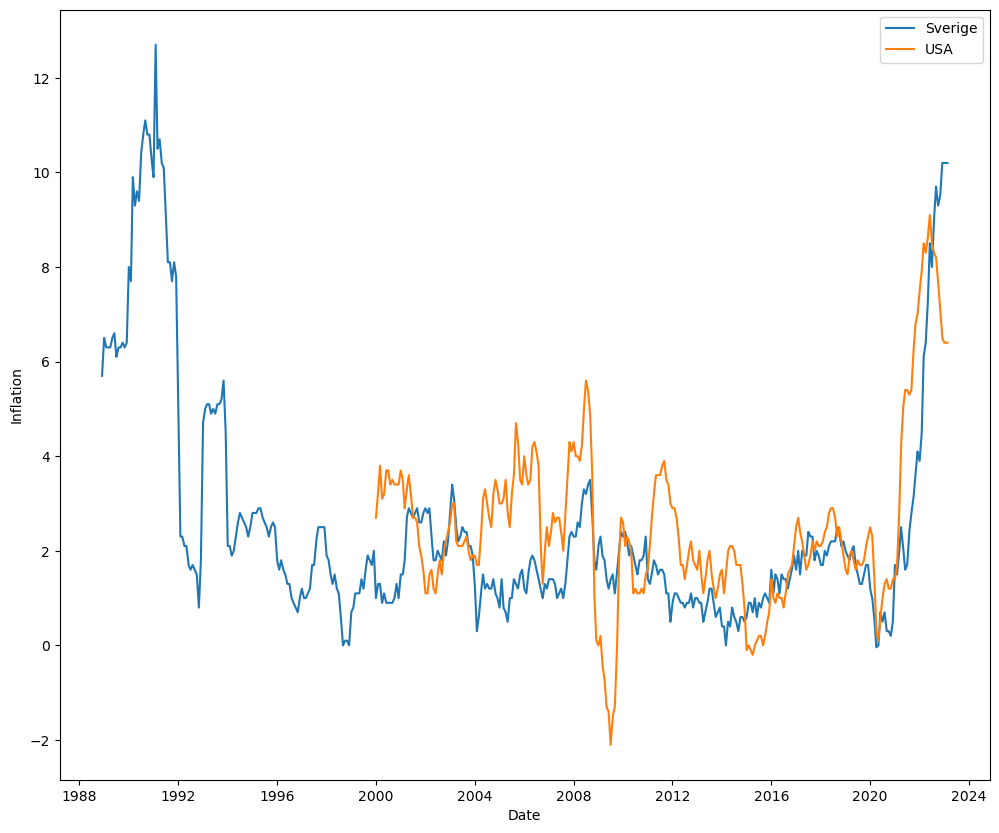

In [8]:
def add_horizon_columns(inflation, horizons):
    # print(horizons)
    for horizon in  horizons:
        # print(horizon)
        inflation['US_inflation_'+str(horizon)] = inflation['US_inflation'].rolling(horizon, 1).mean()
        inflation['SE_inflation_'+str(horizon)] = inflation['SE_inflation'].rolling(horizon, 1).mean()
                
        # print(inflation.columns)        
    return inflation


def initiate_data(inflation, df_dates, lang_dict, value_name):
    # display(inflation)
    inflation = inflation.melt(id_vars=['Year'], var_name='month', value_name=value_name)

    # use lang_dict to translate month names to numbers
    inflation['month'] = inflation['month'].map(lang_dict)

    inflation['date'] = pd.to_datetime(inflation['Year'].astype(str) + '-' + inflation['month'].astype(str))
    inflation.set_index('date', inplace=True)
    inflation.drop(['Year', 'month'], axis=1, inplace=True)
    inflation = df_dates.merge(inflation, how='left', left_on='date', right_index=True)
    inflation.set_index('date', inplace=True)
    inflation[value_name] = inflation[value_name].astype(str)
    inflation[value_name] = inflation[value_name].str.replace(',', '.')
    inflation[value_name] = inflation[value_name].str.replace(chr(8209), chr(45))
    inflation[value_name] = inflation[value_name].astype(float)
    inflation[value_name].interpolate(method='linear', inplace=True)
    return inflation


def get_inflation_data(graph=False):
    df_dates = pd.DataFrame(pd.date_range('1988-12-01', pd.to_datetime('today').date()), columns=['date'])
    
    US_inflation = pd.read_html('https://www.usinflationcalculator.com/inflation/current-inflation-rates/')
    US_inflation = US_inflation[0]
    # replace the cell including string starting with "Avail" with the NaN
    US_inflation.replace(to_replace=r'^Avail.*$', value=np.nan, regex=True, inplace=True)
    # set the first row as the header and drop the first row
    US_inflation.columns = US_inflation.iloc[0]
    US_inflation.drop(US_inflation.index[0], inplace=True)
    US_inflation.drop('Ave', axis=1, inplace=True)

    SE_inflation = pd.read_html('https://www.scb.se/hitta-statistik/statistik-efter-amne/priser-och-konsumtion/konsumentprisindex/konsumentprisindex-kpi/pong/tabell-och-diagram/konsumentprisindex-med-fast-ranta-kpif-och-kpif-xe/kpif-12-manadersforandring/')
    SE_inflation = SE_inflation[0]
    SE_inflation.rename(columns={'År': 'Year'}, inplace=True)

    se_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', Maj='5', Jun='6', Jul='7', Aug='8', Sep='9', Okt='10', Nov='11', Dec='12')
    us_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', May='5', Jun='6', Jul='7', Aug='8', Sep='9', Oct='10', Nov='11', Dec='12')
    #
    SE_inflation = initiate_data(SE_inflation, df_dates, se_dict, value_name='SE_inflation')
    SE_inflation['SE_inflation'] = SE_inflation['SE_inflation'] / 10  # SE_inflation is in percent, divide by 10 to get decimal
    US_inflation = initiate_data(US_inflation, df_dates, us_dict,  value_name='US_inflation')

    if graph:
        # Do a simple plot
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.plot(SE_inflation.index, SE_inflation['SE_inflation'], label='Sverige')
        ax.plot(US_inflation.index, US_inflation['US_inflation'], label='USA')
        ax.set_xlabel('Date')
        ax.set_ylabel('Inflation')
        ax.legend()
        plt.show()

    # concat and set one column to US_index and the other to SE_index
    inflations = pd.concat([US_inflation, SE_inflation], axis=1)
    inflations = inflations.dropna()
    inflations = add_horizon_columns(inflations, [75,90,250])
    return inflations

inflations = get_inflation_data(graph=True)

In [9]:
list(inflations.columns)

['US_inflation',
 'SE_inflation',
 'US_inflation_75',
 'SE_inflation_75',
 'US_inflation_90',
 'SE_inflation_90',
 'US_inflation_250',
 'SE_inflation_250']

In [10]:
# fill up a dataframe with all dates from 2015 up to today
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


In [11]:
def fill_rolling(df, ticker_name, window):
    """Beräknar rolling trend för en ticker"""

    df[ticker_name+'_tr'] = df[ticker_name].fillna(method='ffill')/30   # Basvärde att räkna från
    df[ticker_name+'_'+str(window)] = df[ticker_name+'_tr'].rolling(window, 1).mean()
    # remove column
    df.drop(ticker_name+'_tr', axis=1, inplace=True)
    
    return df

## get Google Trends Crypto data


Bitcoin
Ethereum
Bitcoin Cash
0X
Ripple


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_30,Ethereum_30,Bitcoin Cash_30,0X_30,Ripple_30,Bitcoin_90,Ethereum_90,Bitcoin Cash_90,0X_90,Ripple_90,Bitcoin_250,Ethereum_250,Bitcoin Cash_250,0X_250,Ripple_250
2023-02-13,0.766667,0.633333,0.133333,0.166667,0.1,0.026815,0.022370,0.004444,0.002407,0.003333,0.026481,0.021457,0.004062,0.002691,0.003333,0.030938,0.030169,0.004542,0.003849,0.003333
2023-02-14,0.766667,0.633333,0.133333,0.166667,0.1,0.026741,0.022296,0.004444,0.002593,0.003333,0.026420,0.021383,0.004062,0.002704,0.003333,0.030836,0.030067,0.004538,0.003858,0.003333
2023-02-15,0.766667,0.633333,0.133333,0.166667,0.1,0.026667,0.022222,0.004444,0.002778,0.003333,0.026358,0.021309,0.004062,0.002716,0.003333,0.030733,0.029964,0.004533,0.003867,0.003333
2023-02-16,0.766667,0.633333,0.133333,0.166667,0.1,0.026593,0.022148,0.004444,0.002963,0.003333,0.026296,0.021235,0.004062,0.002728,0.003333,0.030631,0.029862,0.004529,0.003876,0.003333
2023-02-17,0.766667,0.633333,0.133333,0.166667,0.1,0.026519,0.022074,0.004444,0.003148,0.003333,0.026235,0.021160,0.004062,0.002741,0.003333,0.030529,0.029760,0.004524,0.003884,0.003333


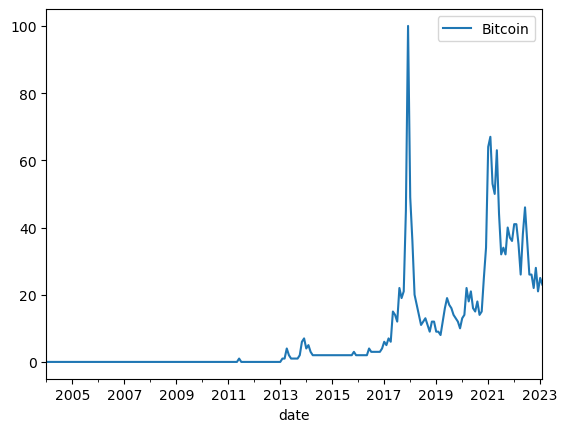

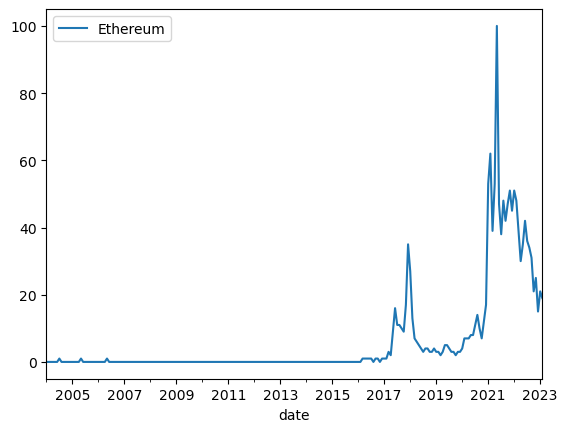

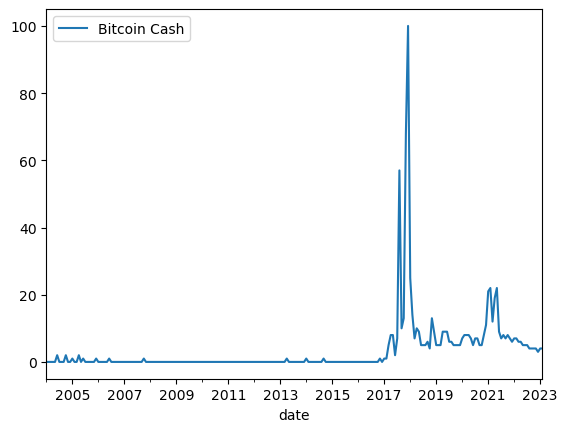

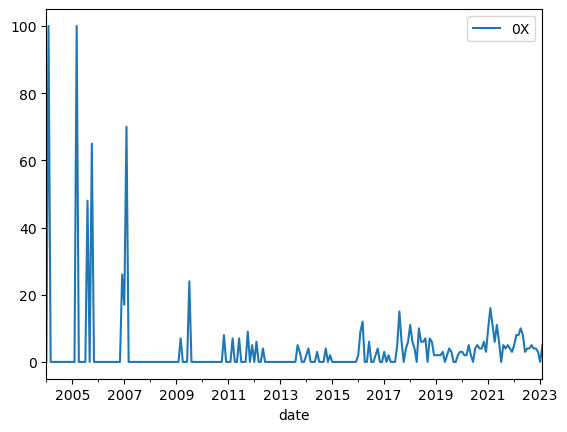

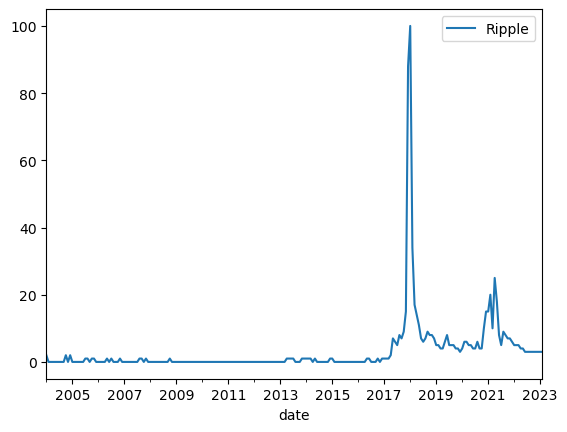

In [12]:
# get google trends data
from pytrends.request import TrendReq

pytrends = TrendReq()
df_trend = get_all_dates()
for ticker_name in ticker_names:
    print(ticker_name)
    pytrends.build_payload(kw_list=[ticker_name], cat=7, timeframe='all')
    df_temp = pytrends.interest_over_time()
    df_temp = df_temp.drop(columns=['isPartial'])
    df_temp.plot()
    df_trend = df_trend.merge(df_temp, how='left', left_index=True, right_index=True)
    df_trend[ticker_name] = df_trend[ticker_name].fillna(method='ffill')/30
    # df_trend[ticker_name+'_30'] = df_trend[ticker_name].rolling(30, 1).mean()
    df_trend = fill_rolling(df_trend, ticker_name, 30)
    # df_trend[ticker_name+'_90'] = df_trend[ticker_name].rolling(90, 1).mean()
    df_trend = fill_rolling(df_trend, ticker_name, 90)
    # df_trend[ticker_name+'_250'] = df_trend[ticker_name].rolling(250, 1).mean()
    df_trend = fill_rolling(df_trend, ticker_name, 250)
    
    
# gruppera kolumnerna per typ av data
df_trend = df_trend[ticker_names + [ticker_name+'_30' for ticker_name in ticker_names] + [ticker_name+'_90' for ticker_name in ticker_names] + [ticker_name+'_250' for ticker_name in ticker_names]]

df_trend.tail()


In [13]:
df_trend.to_csv('google_trends.csv')


## skapa alla modellerna

In [14]:
df_trend.query('index>"2017-01-01"').sample(6)


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_30,Ethereum_30,Bitcoin Cash_30,0X_30,Ripple_30,Bitcoin_90,Ethereum_90,Bitcoin Cash_90,0X_90,Ripple_90,Bitcoin_250,Ethereum_250,Bitcoin Cash_250,0X_250,Ripple_250
2022-01-20,1.366667,1.700000,0.233333,0.166667,0.166667,0.043704,0.054444,0.007407,0.004815,0.005926,0.042049,0.053926,0.007506,0.004420,0.006901,0.042756,0.054836,0.009249,0.004884,0.008511
2022-03-16,1.166667,1.300000,0.200000,0.266667,0.166667,0.042000,0.048000,0.007185,0.008889,0.005556,0.043444,0.052148,0.007395,0.006815,0.005741,0.040724,0.051178,0.007844,0.005111,0.007187
2019-09-21,0.466667,0.100000,0.166667,0.000000,0.166667,0.016222,0.003333,0.005889,0.001000,0.005556,0.017901,0.003889,0.006667,0.002852,0.005815,0.015093,0.003876,0.007449,0.002307,0.005822
2017-10-18,0.700000,0.300000,0.433333,0.000000,0.300000,0.022444,0.010444,0.013111,0.002667,0.009111,0.021753,0.011407,0.029358,0.008642,0.008333,0.014996,0.009218,0.014396,0.003831,0.005693
2019-02-04,0.300000,0.100000,0.166667,0.066667,0.166667,0.010000,0.003333,0.005556,0.002222,0.005556,0.012037,0.003716,0.009457,0.003407,0.007210,0.012333,0.003884,0.007187,0.004987,0.007884
2020-05-01,0.700000,0.266667,0.233333,0.066667,0.166667,0.020111,0.007815,0.008852,0.005444,0.005556,0.020185,0.007790,0.008877,0.003333,0.006284,0.016182,0.004956,0.007067,0.002382,0.005138


In [15]:
def get_all(tickers):
    df = pd.DataFrame()
    for ticker in tickers:
        all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

In [16]:
df_org= get_all(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [17]:
display(df_org.isna().sum())
display(df_org.head())
df_org.shape

BTC-USD       0
ETH-USD    1149
BCH-USD    1149
ZRX-USD    1081
XRP-USD    1149
dtype: int64

,BTC-USD,ETH-USD,BCH-USD,ZRX-USD,XRP-USD
Date,,,,,
2014-09-17,457.334015,NaN,NaN,NaN,NaN
2014-09-18,424.440002,NaN,NaN,NaN,NaN
2014-09-19,394.795990,NaN,NaN,NaN,NaN
2014-09-20,408.903992,NaN,NaN,NaN,NaN
2014-09-21,398.821014,NaN,NaN,NaN,NaN


(3075, 5)

In [18]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined



Backtest av modellerna

In [19]:
def backtest(data, target, model, predictors, gap=0, proba_val=0.6, start=360, step=180):
    """"
    Args:
        data (DataFrame): Data to use for backtesting
        taregt (str): Name of the target column
        model: Tex RandomForestClassifier
        predictors: Features in data to use for backtesting
        proba_val (float): threshold för att få 1 annars 0 i predictions.
        start (int, optional): Hur många rader in i data skall vi starta testet. Defaults to 180.
        step (int, optional): Hur många rader skall vi ta i varje batch framåt. Defaults to 60.

    Returns:
        DataFrame: Två kolumner med true_y och prediktioner 
    """
    all_predictions = []
    print('last date', (data.iloc[-1].name).date())
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[(i+gap):(i+step)].copy()
        predictions = fit_predict(train, test, target, predictors, model, proba_val=proba_val)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


def print_results(predictions, target):
    prec = precision_score(predictions[target], predictions["Predictions"])
    print(f'Fördelning av {target}: 1 vs 0:')
    print(predictions[target].value_counts() / predictions.shape[0])

    predictions.Predictions = predictions.Predictions.astype(int)
    print(predictions.value_counts())
    print(f"Precision:\t{prec:.4f}")
    return prec


### Beräkna predictors

In [20]:
def add_predictors(df_, ticker, target, horizons=[2,5,60,250], ETH_BTC=False):
    df = df_.copy()
    ticker_name = ticker[:3]
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    predictors=[]
     
    if ETH_BTC: 
        df['ETH_BTC_ratio'] = df['ETH-USD']/df['BTC-USD']
        predictors += ['ETH_BTC_ratio']
        
        df['ETH_BTC_lag1'] = df['ETH_BTC_ratio'].shift(1)
        predictors += ['ETH_BTC_lag1']
        
        df['ETH_BTC_lag2'] = df['ETH_BTC_ratio'].shift(2)
        predictors += ['ETH_BTC_lag2']
        
        if ticker not in ['BTC-USD', 'ETH-USD']:
            df[ticker_name+'_BTC_ratio'] = df[ticker]/df['BTC-USD']
            predictors += [ticker_name+'_BTC_ratio']
        
            df[ticker_name+'_BTC_lag1'] = df[ticker_name+'_BTC_ratio'].shift(1)
            predictors += [ticker_name+'_BTC_lag1']
            
            df[ticker_name+'_BTC_lag2'] = df[ticker_name+'_BTC_ratio'].shift(2)
            predictors += [ticker_name+'_BTC_lag2']
            
            df[ticker_name+'_ETH_ratio'] = df[ticker]/df['ETH-USD']
            predictors += [ticker_name+'_ETH_ratio']
        
            df[ticker_name+'_ETH_lag1'] = df[ticker_name+'_ETH_ratio'].shift(1)
            predictors += [ticker_name+'_ETH_lag1']
            
            df[ticker_name+'_ETH_lag2'] = df[ticker_name+'_ETH_ratio'].shift(2)
            predictors += [ticker_name+'_ETH_lag2']
            
    df['stoch_k'] = ta.momentum.stochrsi_k(df[ticker], window=10)

    # Target
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    # df.dropna(inplace=True)

    for horizon in horizons:
        rolling_averages = df.rolling(horizon, min_periods=1).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]

        # edit_column = f"edit_{horizon}"
        # df[edit_column] = rolling_averages['edit_count']
        ## Den ovan ändras till min Google Trends och görs på annan plats
        
        rolling = df.rolling(horizon,closed='left', min_periods=1).mean()
        
        trend_column = f"Trend_{horizon}"
        target_name = 'Tomorrow' if target=='y1' else 'After_tomorrow'
        df[trend_column] = rolling[target_name]     #### OBS! Skilj trend_column från Google Trends

        predictors += [ratio_column, trend_column]

    df['day_of_month'] = df.index.day
    predictors += ['day_of_month']
    
    df['day_of_week'] = df.index.dayofweek
    predictors += ['day_of_week']
    
    df['month'] = df.index.month
    predictors += ['month']

    predictors += ['stoch_k']
    # df = df.dropna()
    return df, predictors


In [21]:
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
pd.options.display.precision = 4      # default 6
# print(tickers[0])
# df, predictors = add_predictors(df_org, tickers[0], 'y1')
# df[predictors+['y1']]


### Vi använder XGBoost / CatBoost

Loop öve all tickers och skapa 2 modeller  
    En mot y1 (tomorrow) och en mot y2 (day after tomorrow)  
    spara båda modellerna  
Totalt 2 modeller per ticker    

Modellens namn:  
    ticker[:3]_y1  
    ticker[:3]_y2

In [22]:
def add_google_trends(df_, df_trend, ticker, predictors):
    df = df_.copy()
    
    lookup = {'BTC-USD': 'Bitcoin', 'ETH-USD': 'Ethereum', 'BCH-USD': 'Bitcoin Cash', 'XRP-USD': 'Ripple', 'ZRX-USD': '0X'}
    ticker_namn = lookup[ticker]
    
    df[ticker_namn + '_goog30'] = df_trend[ticker_namn + '_30']
    predictors.append(ticker_namn + '_goog30')
    df[ticker_namn + '_goog90'] = df_trend[ticker_namn + '_90']
    predictors.append(ticker_namn + '_goog90')
    df[ticker_namn + '_goog250'] = df_trend[ticker_namn + '_250']
    predictors.append(ticker_namn + '_goog250')
    
    return df, predictors


##### Generate all xgbModels and save them #####
def generate_all_xgbmodels(df_org, tickers, horizons=[2, 5, 30, 60, 250], save=True, remove=[], ETH_BTC=False, use_inflations=False):
    xgb_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7,
                'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4}
    precision_list=[]
    
    df_inflations = get_inflation_data(graph=False)
    for ticker in tickers:
        namn = ticker[:3]
        print(namn+'1')
        target = 'y1'
        model = xgb.XGBClassifier(**xgb_params,  random_state=2022, n_jobs=-1)
        df, predictors = add_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=ETH_BTC)
        df, predictors = add_google_trends(df, df_trend, ticker, predictors)
        
        if use_inflations:
            df = pd.concat([df, df_inflations], axis=1)
            predictors += list(df_inflations.columns)
            df.dropna(subset=['y1'], inplace=True)
            
        if remove != []:
            for col in remove:
                predictors.remove(col)
        predictions_xgb = backtest(df, target, model, predictors, proba_val= 0.55, step=30)

        precision_list.append((namn+'1', print_results(predictions_xgb, target)))

        # display(pd.DataFrame(model.feature_importances_,columns=['importance'], index=predictors).sort_values(by='importance', ascending=False))
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind='bar', title=namn+'1' , figsize=(18, 10)).get_figure())
        plt.show( )
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = xgb.XGBClassifier(early_stopping_rounds=100, 
                                **xgb_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[predictors], train[target],
                eval_set=[(train[predictors], train[target]),
                        (test[predictors], test[target])],
                verbose=False)
        # display(predictors)
        if save:
            model.save_model(f'{namn}_{target}.json')


        print(namn+'2')
        target='y2'
        model = xgb.XGBClassifier(**xgb_params,  random_state=2022, n_jobs=-1)
        df, predictors = add_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=ETH_BTC)
        df, predictors = add_google_trends(df, df_trend, ticker, predictors)
        
        if use_inflations:
            df = pd.concat([df, df_inflations], axis=1)
            predictors += list(df_inflations.columns)
            df.dropna(subset=['y2'], inplace=True)
            
        if remove != []:
            for col in remove:
                predictors.remove(col)
        predictions_xgb = backtest(df, target, model, predictors, proba_val=0.55, step=30)

        precision_list.append((namn+'2',print_results(predictions_xgb, target)))
        
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind = 'bar', title=namn+'2', figsize = (18, 10)).get_figure())
        plt.show()
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = xgb.XGBClassifier(early_stopping_rounds=100, 
                                **xgb_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[predictors], train[target],
                eval_set=[(train[predictors], train[target]),
                        (test[predictors], test[target])],
                verbose=False)
        if save:
            model.save_model(f'{namn}_{target}.json')
        
    return precision_list,predictors


In [23]:
##### Generate all catModels and save them #####


#####################################
#####    OBS OBS OBS OBS OBS    #####
#####    DENNA ÄR INTE KLAR     #####
#####################################
def generate_all_catmodels(df_org, tickers, horizons=[2, 5, 30, 60, 250], save=True, remove=[], ETH_BTC=False, use_inflations=False):
    logging.error('generate_all_catmodels is not finished')
    logging.error('generate_all_catmodels is not finished')
    logging.error('generate_all_catmodels is not finished')
    logging.error('generate_all_catmodels is not finished')
    logging.error('generate_all_catmodels is not finished')

    
    cat_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7,
                'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4}
    precision_list=[]
    
    df_inflations = get_inflation_data(graph=False)
    for ticker in tickers:
        namn = ticker[:3]
        print(namn+'1')
        target = 'y1'
        model = CatBoostClassifier(**cat_params,  random_state=2022, n_jobs=-1)
        df, predictors = add_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=ETH_BTC)
        df, predictors = add_google_trends(df, df_trend, ticker, predictors)
        
        if use_inflations:
            df = pd.concat([df, df_inflations], axis=1)
            predictors += list(df_inflations.columns)
            df.dropna(subset=['y1'], inplace=True)
            
        if remove != []:
            for col in remove:
                predictors.remove(col)
        predictions_cat = backtest(df, target, model, predictors, proba_val= 0.55, step=30)

        precision_list.append((namn+'1', print_results(predictions_cat, target)))

        # display(pd.DataFrame(model.feature_importances_,columns=['importance'], index=predictors).sort_values(by='importance', ascending=False))
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind='bar', title=namn+'1' , figsize=(18, 10)).get_figure())
        plt.show( )
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = CatBoostClassifier(early_stopping_rounds=100, 
                                **cat_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[predictors], train[target],
                eval_set=[(train[predictors], train[target]),
                        (test[predictors], test[target])],
                verbose=False)
        # display(predictors)
        if save:
            model.save_model(f'{namn}_{target}.json')


        print(namn+'2')
        target='y2'
        model = CatBoostClassifier(**cat_params,  random_state=2022, n_jobs=-1)
        df, predictors = add_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=ETH_BTC)
        df, predictors = add_google_trends(df, df_trend, ticker, predictors)
        
        if use_inflations:
            df = pd.concat([df, df_inflations], axis=1)
            predictors += list(df_inflations.columns)
            df.dropna(subset=['y2'], inplace=True)
            
        if remove != []:
            for col in remove:
                predictors.remove(col)
        predictions_cat = backtest(df, target, model, predictors, proba_val=0.55, step=30)

        precision_list.append((namn+'2',print_results(predictions_cat, target)))
        
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind = 'bar', title=namn+'2', figsize = (18, 10)).get_figure())
        plt.show()
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = CatBoostClassifier(early_stopping_rounds=100, 
                                **cat_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[predictors], train[target],
                eval_set=[(train[predictors], train[target]),
                        (test[predictors], test[target])],
                verbose=False)
        if save:
            model.save_model(f'{namn}_{target}.json')
        
    return precision_list,predictors

In [24]:
###### tester ######

ticker=tickers[0]
target='y1'
horizons = [2, 5, 30, 60, 250]

df_inflations = get_inflation_data(graph=False)
df_test, predictors = add_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=True)
df_test, predictors = add_google_trends(df_test, df_trend, ticker, predictors)

df_test = pd.concat([df_test, df_inflations], axis=1)
predictors += list(df_inflations.columns)
df_test.dropna(subset=['y1'], inplace=True)
    


In [25]:
df_test[predictors]

,ETH_BTC_ratio,ETH_BTC_lag1,ETH_BTC_lag2,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_30,Trend_30,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,day_of_month,day_of_week,month,stoch_k,Bitcoin_goog30,Bitcoin_goog90,Bitcoin_goog250,US_inflation,SE_inflation,US_inflation_75,SE_inflation_75,US_inflation_90,SE_inflation_90,US_inflation_250,SE_inflation_250
2014-09-17,NaN,NaN,NaN,1.0000,NaN,1.0000,NaN,1.0000,NaN,1.0000,NaN,1.0000,NaN,17.0,2.0,9.0,NaN,0.0022,0.0022,0.0029,1.7,0.46,1.7488,0.4491,1.7924,0.4789,1.7769,0.4432
2014-09-18,NaN,NaN,NaN,0.9627,424.4400,0.9627,424.4400,0.9627,424.4400,0.9627,424.4400,0.9627,424.4400,18.0,3.0,9.0,NaN,0.0022,0.0022,0.0029,1.7,0.47,1.7453,0.4475,1.7887,0.4766,1.7779,0.4435
2014-09-19,NaN,NaN,NaN,0.9638,409.6180,0.9278,409.6180,0.9278,409.6180,0.9278,409.6180,0.9278,409.6180,19.0,4.0,9.0,NaN,0.0022,0.0022,0.0029,1.7,0.48,1.7419,0.4461,1.7850,0.4746,1.7791,0.4438
2014-09-20,NaN,NaN,NaN,1.0176,401.8500,0.9704,409.3800,0.9704,409.3800,0.9704,409.3800,0.9704,409.3800,20.0,5.0,9.0,NaN,0.0022,0.0022,0.0029,1.7,0.49,1.7387,0.4449,1.7813,0.4727,1.7802,0.4442
2014-09-21,NaN,NaN,NaN,0.9875,403.8625,0.9567,406.7402,0.9567,406.7402,0.9567,406.7402,0.9567,406.7402,21.0,6.0,9.0,NaN,0.0022,0.0022,0.0029,1.7,0.50,1.7356,0.4439,1.7777,0.4710,1.7815,0.4446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-12,0.0695,0.0704,0.0700,0.9981,21829.5391,0.9898,22013.7398,0.9687,22491.6446,1.1024,19763.7628,1.0812,20151.6592,12.0,6.0,2.0,0.0721,0.0269,0.0265,0.0310,6.4,10.20,6.4229,10.1997,6.4658,10.1647,7.4611,9.4702
2023-02-13,0.0691,0.0695,0.0704,1.0005,21798.1523,1.0009,21787.4805,0.9684,22519.3714,1.0993,19837.8167,1.0840,20118.0342,13.0,0.0,2.0,0.1101,0.0268,0.0265,0.0309,6.4,10.20,6.4213,10.2000,6.4611,10.1689,7.4508,9.4775
2023-02-14,0.0701,0.0691,0.0695,1.0094,22014.4531,1.0161,21867.8336,0.9848,22564.0382,1.1149,19930.7054,1.1063,20086.4694,14.0,1.0,2.0,0.2253,0.0267,0.0264,0.0308,6.4,10.20,6.4200,10.2000,6.4567,10.1728,7.4407,9.4848
2023-02-15,0.0689,0.0701,0.0691,1.0449,23264.3232,1.0852,22399.1652,1.0723,22668.6452,1.2120,20055.9179,1.2113,20067.3655,15.0,2.0,2.0,0.5281,0.0267,0.0264,0.0307,6.4,10.20,6.4187,10.2000,6.4524,10.1764,7.4306,9.4922


BTC1
last date 2023-02-17
Fördelning av y1: 1 vs 0:
1    0.5396
0    0.4604
Name: y1, dtype: float64
y1  Predictions
1   0              1078
0   0               945
1   1               387
0   1               305
dtype: int64
Precision:	0.5592
Figure(1800x1000)


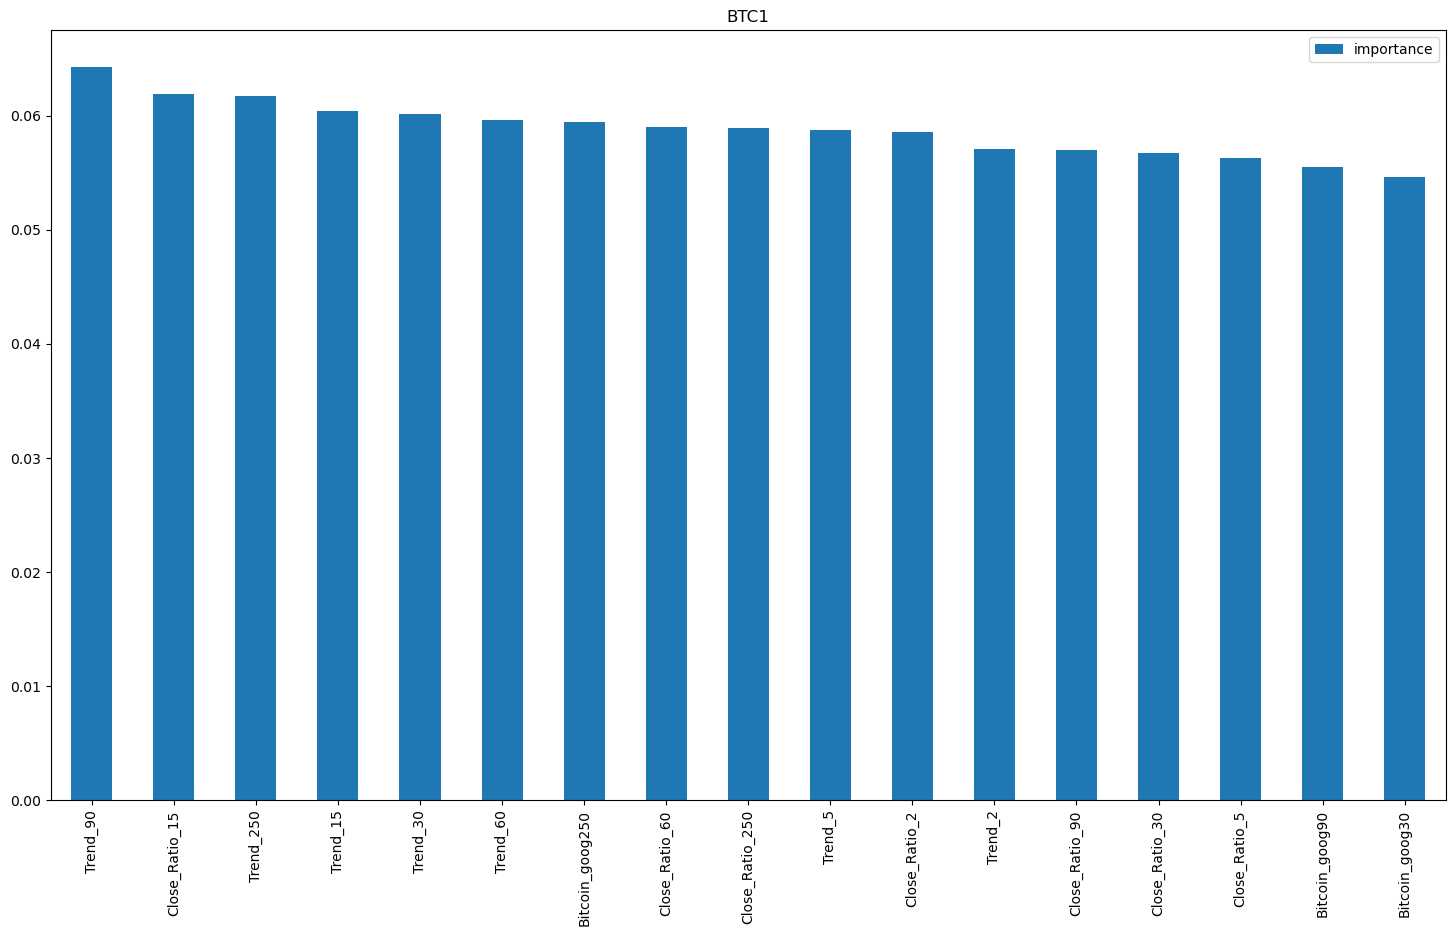

BTC2
last date 2023-02-17
Fördelning av y2: 1 vs 0:
1    0.5543
0    0.4457
Name: y2, dtype: float64
y2  Predictions
1   0              1050
0   0               821
1   1               455
0   1               389
dtype: int64
Precision:	0.5391
Figure(1800x1000)


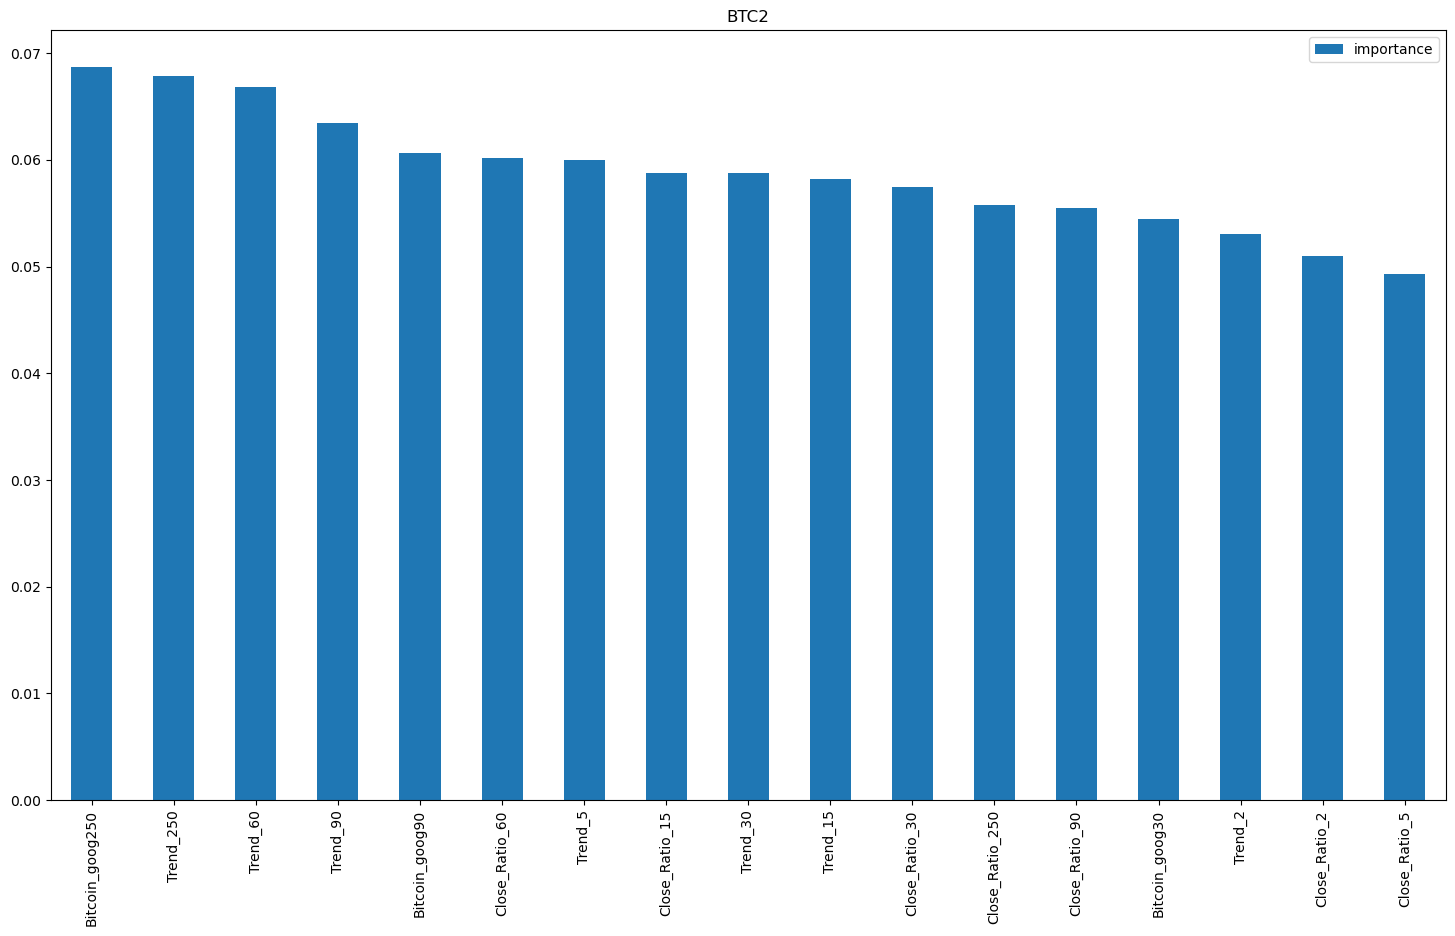

ETH1
last date 2023-02-17
Fördelning av y1: 1 vs 0:
0    0.6354
1    0.3646
Name: y1, dtype: float64
y1  Predictions
0   0              1527
1   0               760
    1               230
0   1               198
dtype: int64
Precision:	0.5374
Figure(1800x1000)


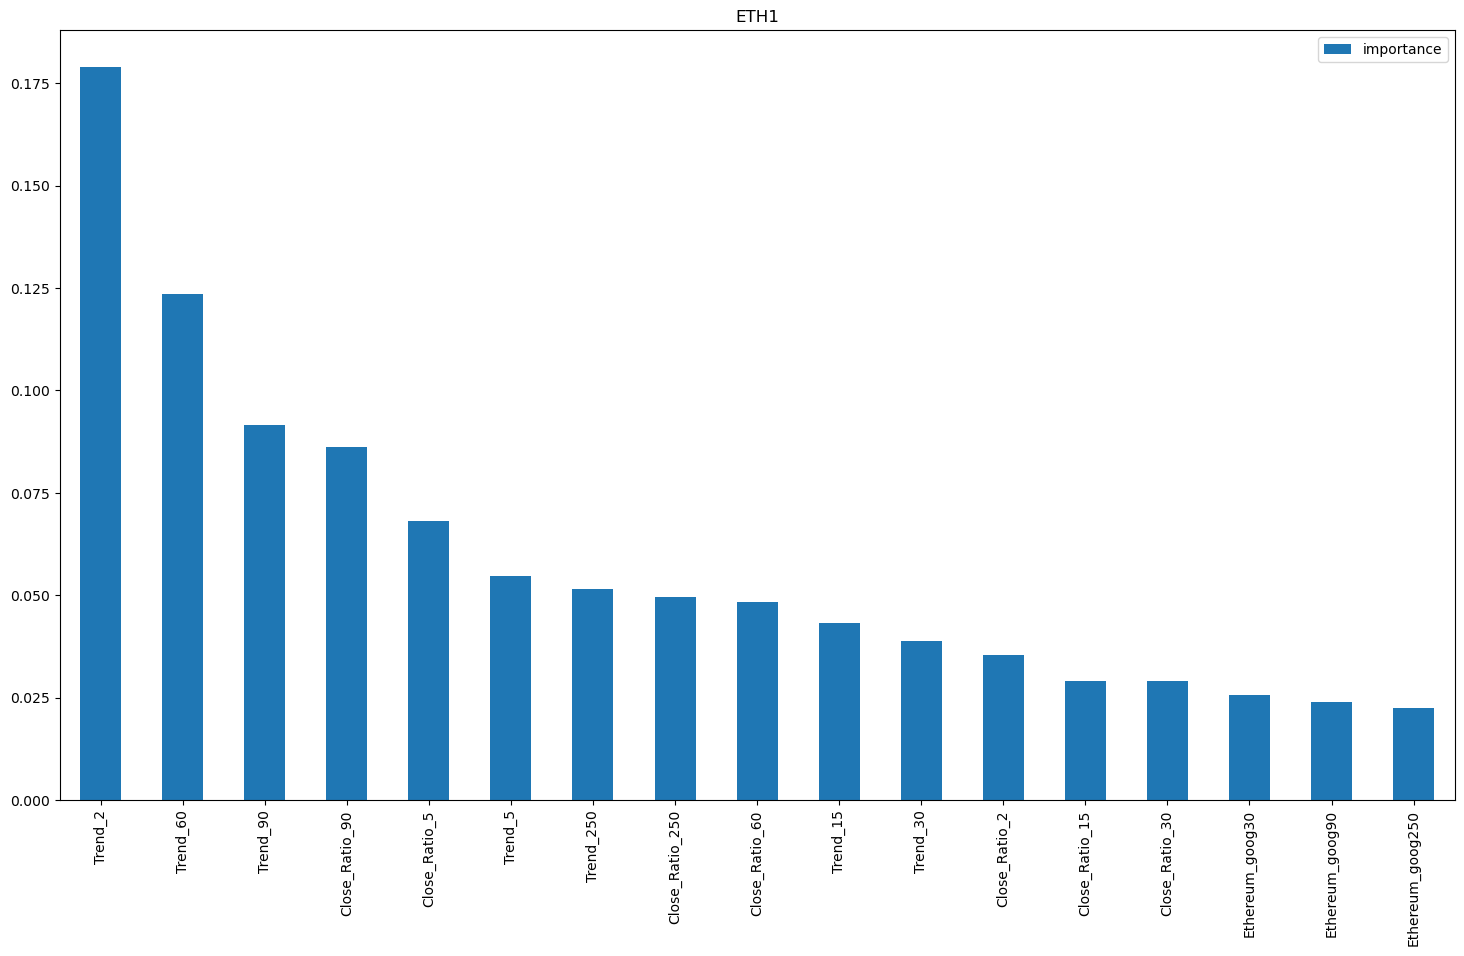

ETH2
last date 2023-02-17
Fördelning av y2: 1 vs 0:
0    0.6331
1    0.3669
Name: y2, dtype: float64
y2  Predictions
0   0              1494
1   0               781
0   1               225
1   1               215
dtype: int64
Precision:	0.4886
Figure(1800x1000)


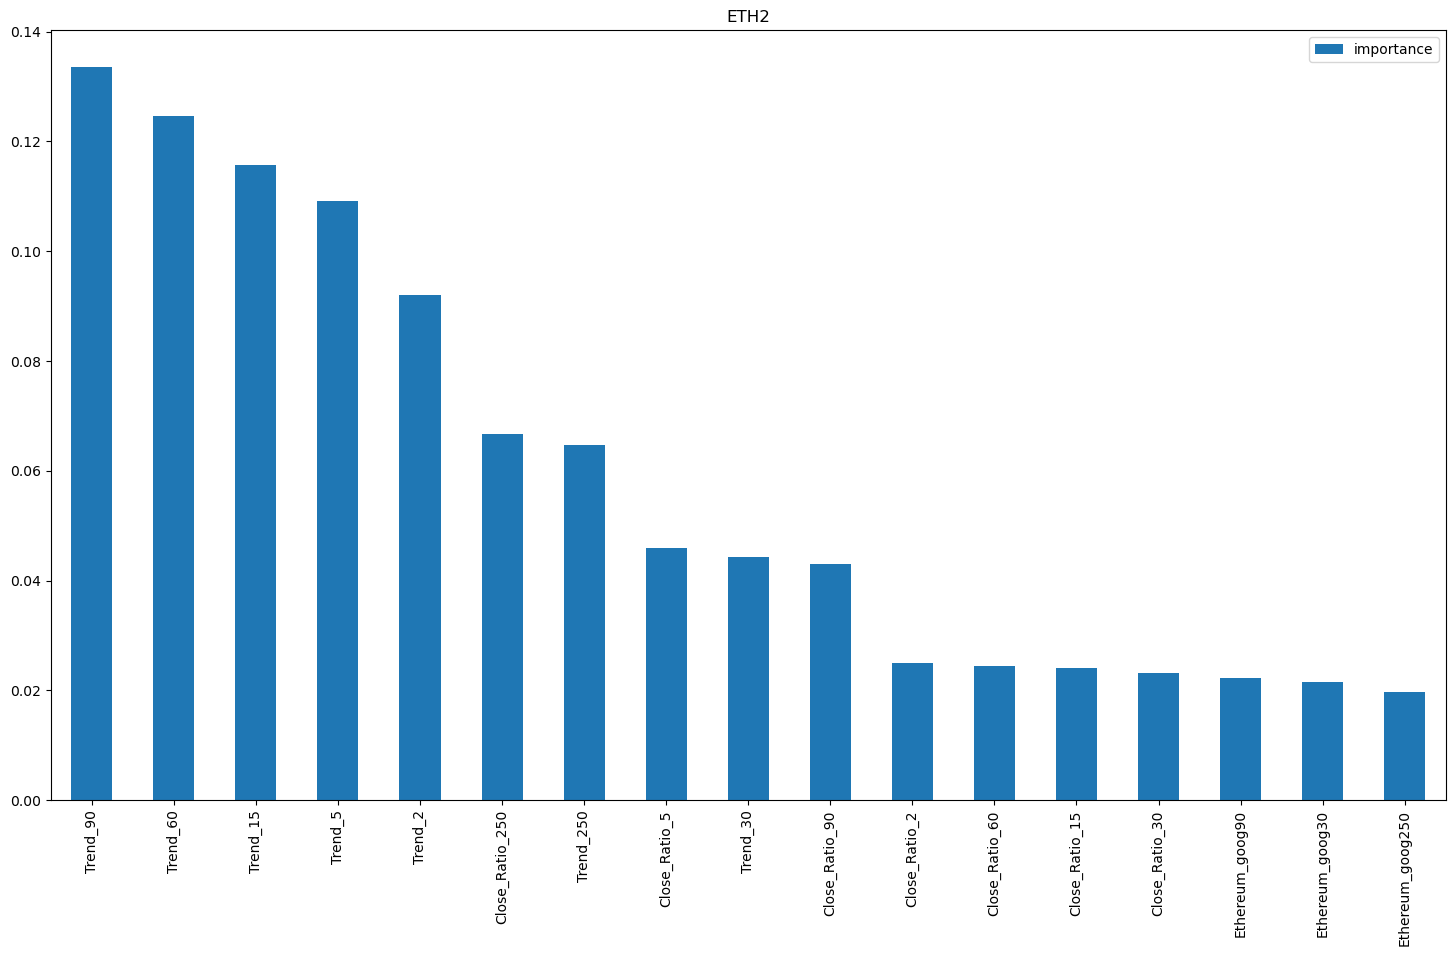

BCH1
last date 2023-02-17
Fördelning av y1: 1 vs 0:
0    0.6545
1    0.3455
Name: y1, dtype: float64
y1  Predictions
0   0              1628
1   0               788
    1               150
0   1               149
dtype: int64
Precision:	0.5017
Figure(1800x1000)


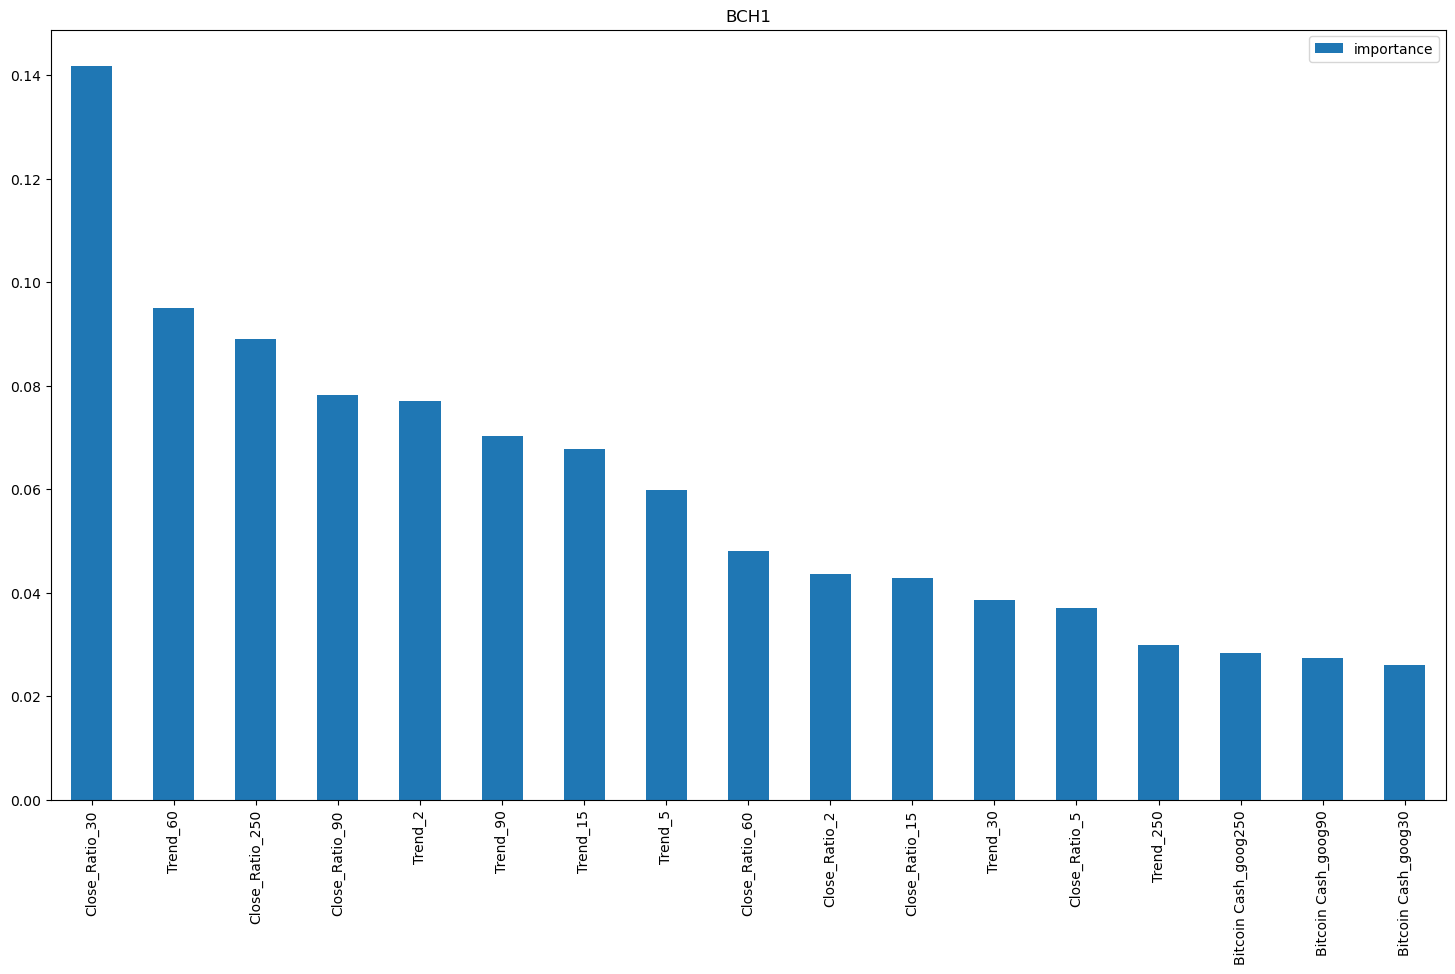

BCH2
last date 2023-02-17
Fördelning av y2: 1 vs 0:
0    0.6611
1    0.3389
Name: y2, dtype: float64
y2  Predictions
0   0              1597
1   0               720
    1               200
0   1               198
dtype: int64
Precision:	0.5025
Figure(1800x1000)


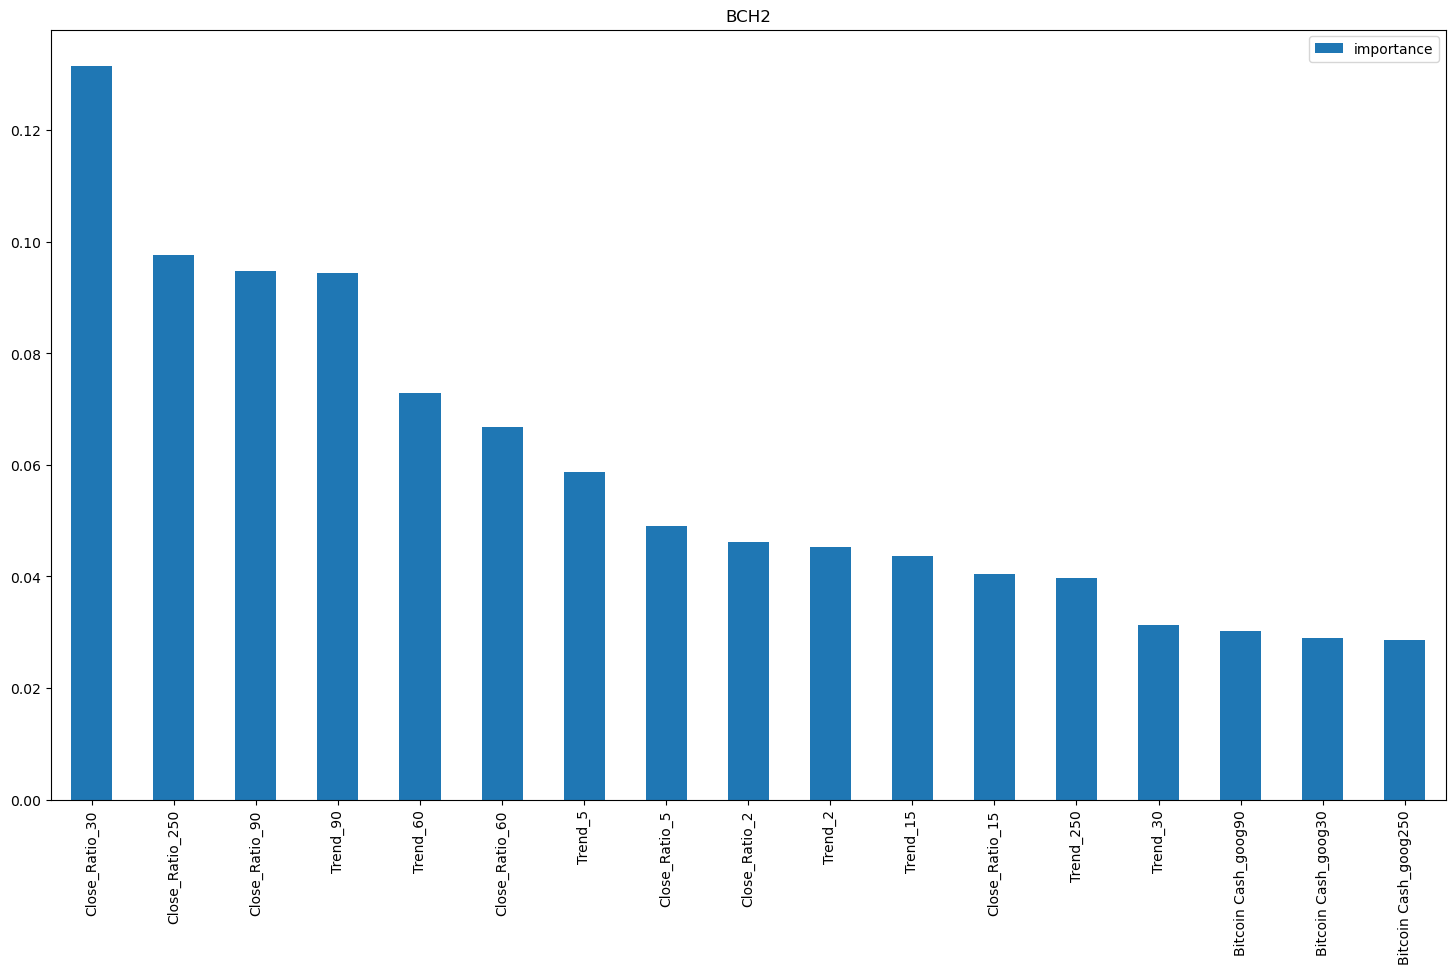

ZRX1
last date 2023-02-17
Fördelning av y1: 1 vs 0:
0    0.6383
1    0.3617
Name: y1, dtype: float64
y1  Predictions
0   0              1580
1   0               813
    1               169
0   1               153
dtype: int64
Precision:	0.5248
Figure(1800x1000)


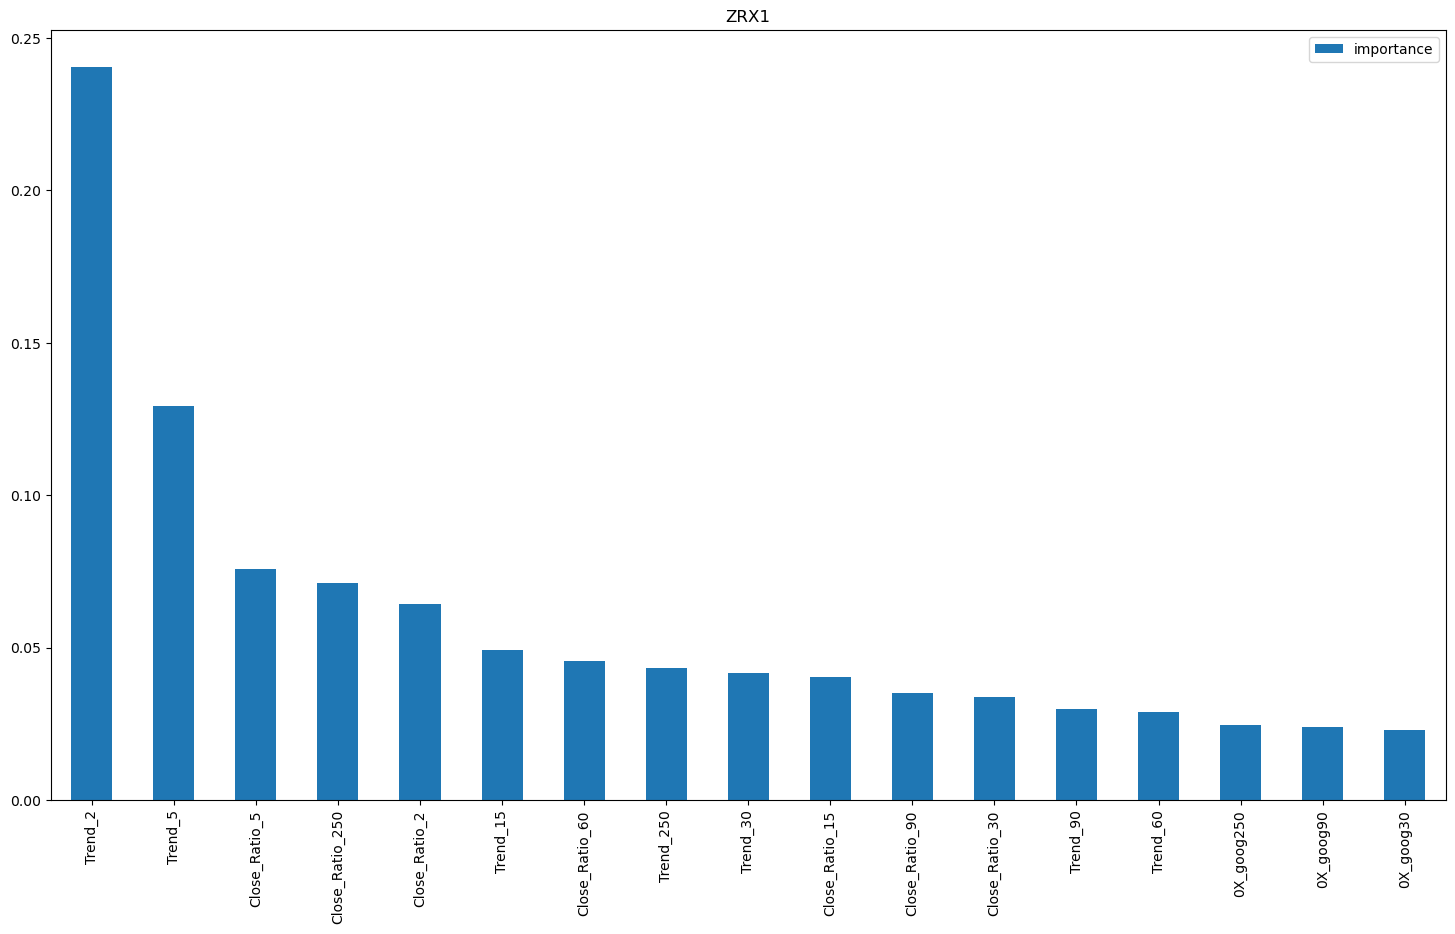

ZRX2
last date 2023-02-17
Fördelning av y2: 1 vs 0:
0    0.6457
1    0.3543
Name: y2, dtype: float64
y2  Predictions
0   0              1555
1   0               737
    1               225
0   1               198
dtype: int64
Precision:	0.5319
Figure(1800x1000)


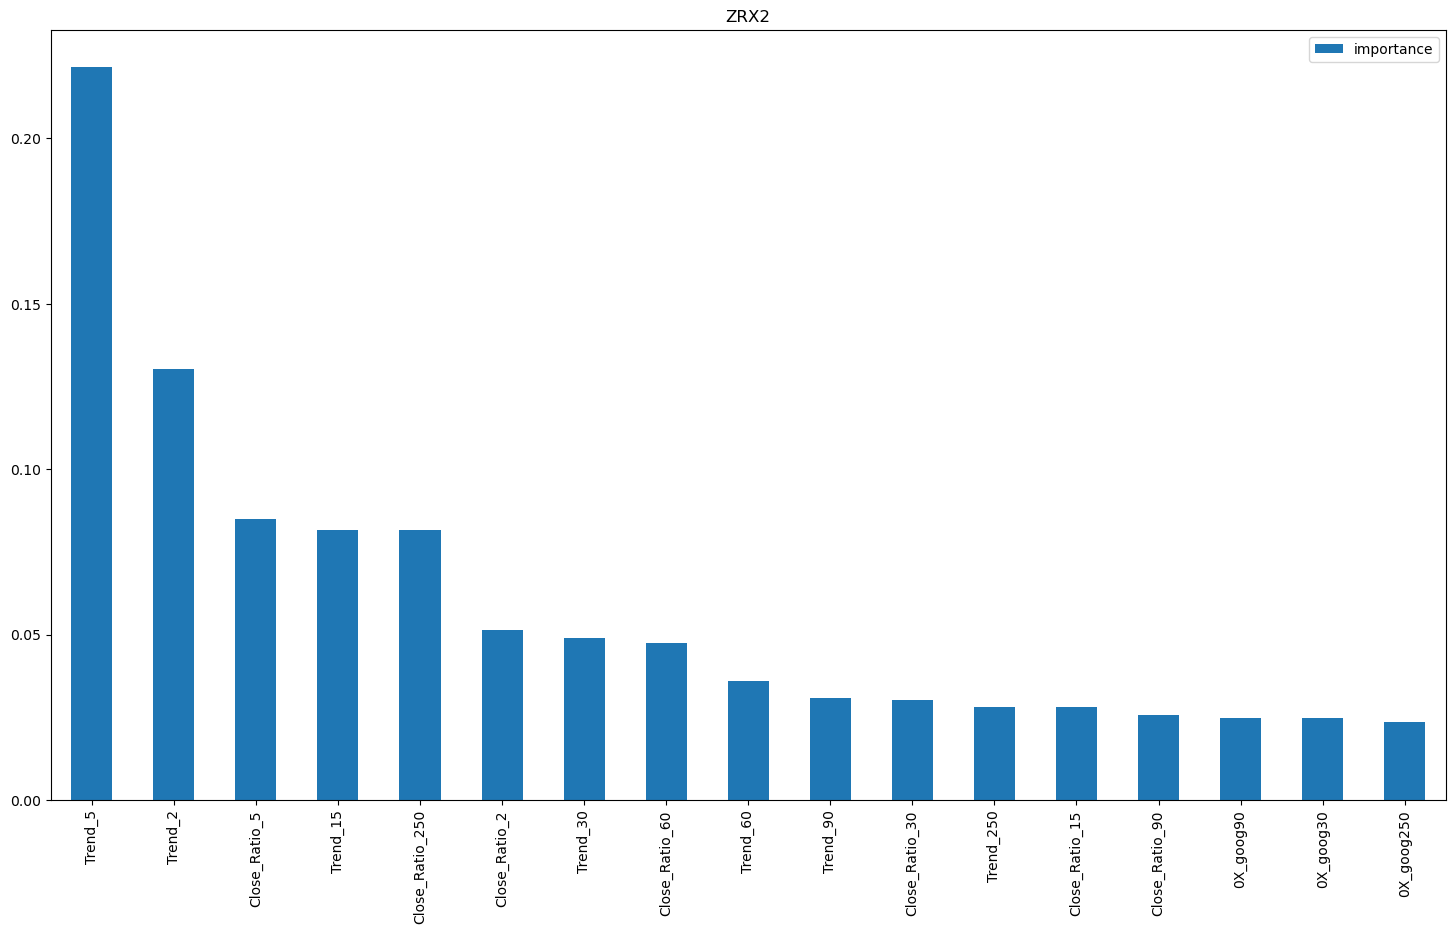

XRP1
last date 2023-02-17
Fördelning av y1: 1 vs 0:
0    0.6512
1    0.3488
Name: y1, dtype: float64
y1  Predictions
0   0              1607
1   0               737
    1               210
0   1               161
dtype: int64
Precision:	0.5660
Figure(1800x1000)


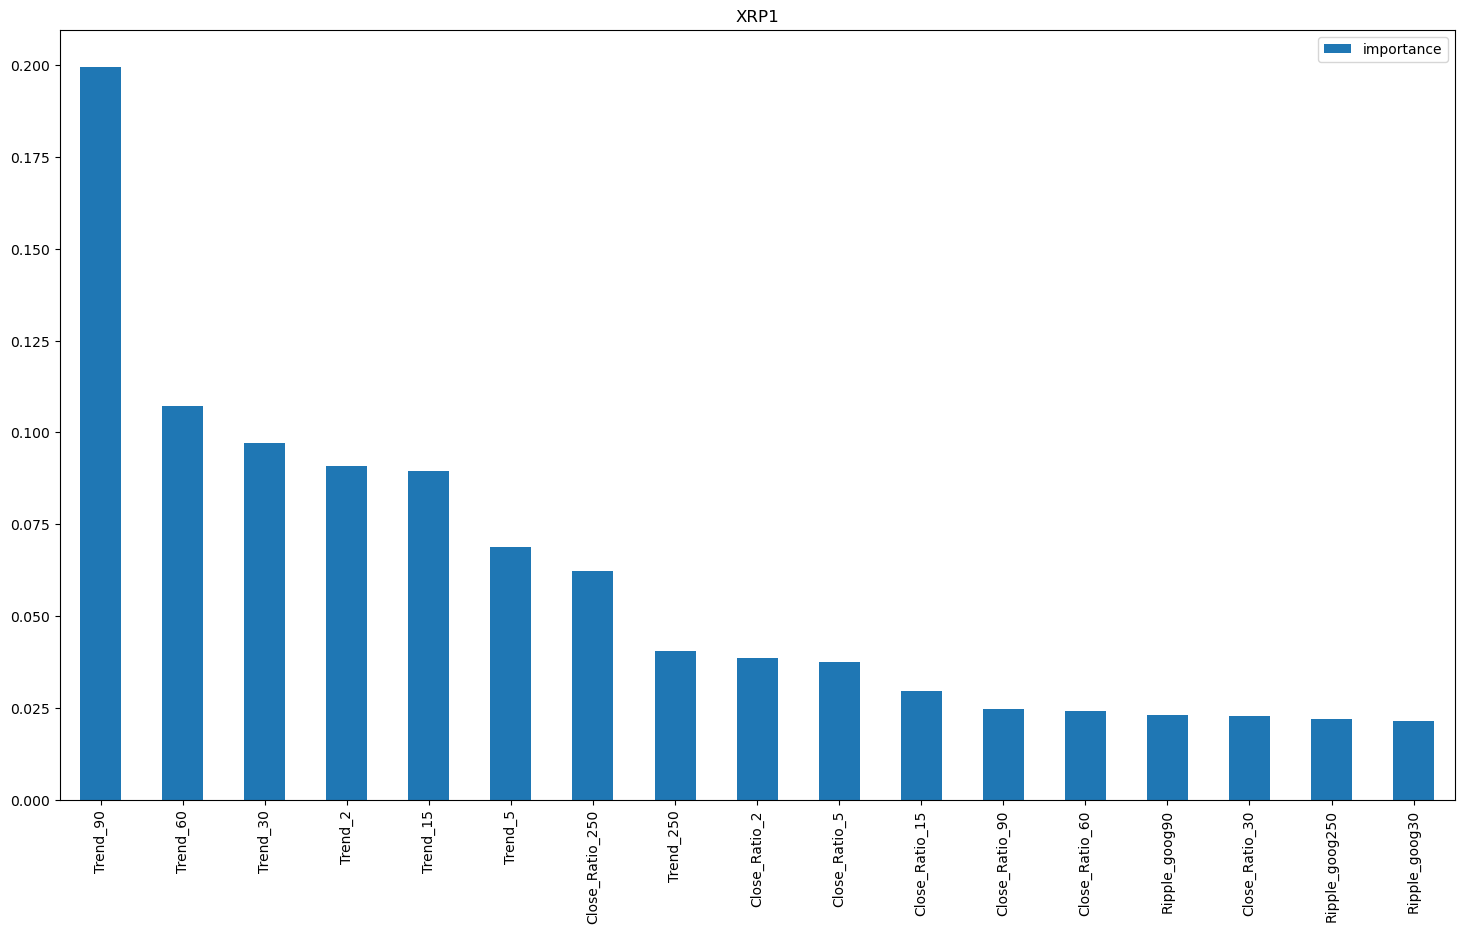

XRP2
last date 2023-02-17
Fördelning av y2: 1 vs 0:
0    0.6634
1    0.3366
Name: y2, dtype: float64
y2  Predictions
0   0              1615
1   0               751
0   1               186
1   1               163
dtype: int64
Precision:	0.4670
Figure(1800x1000)


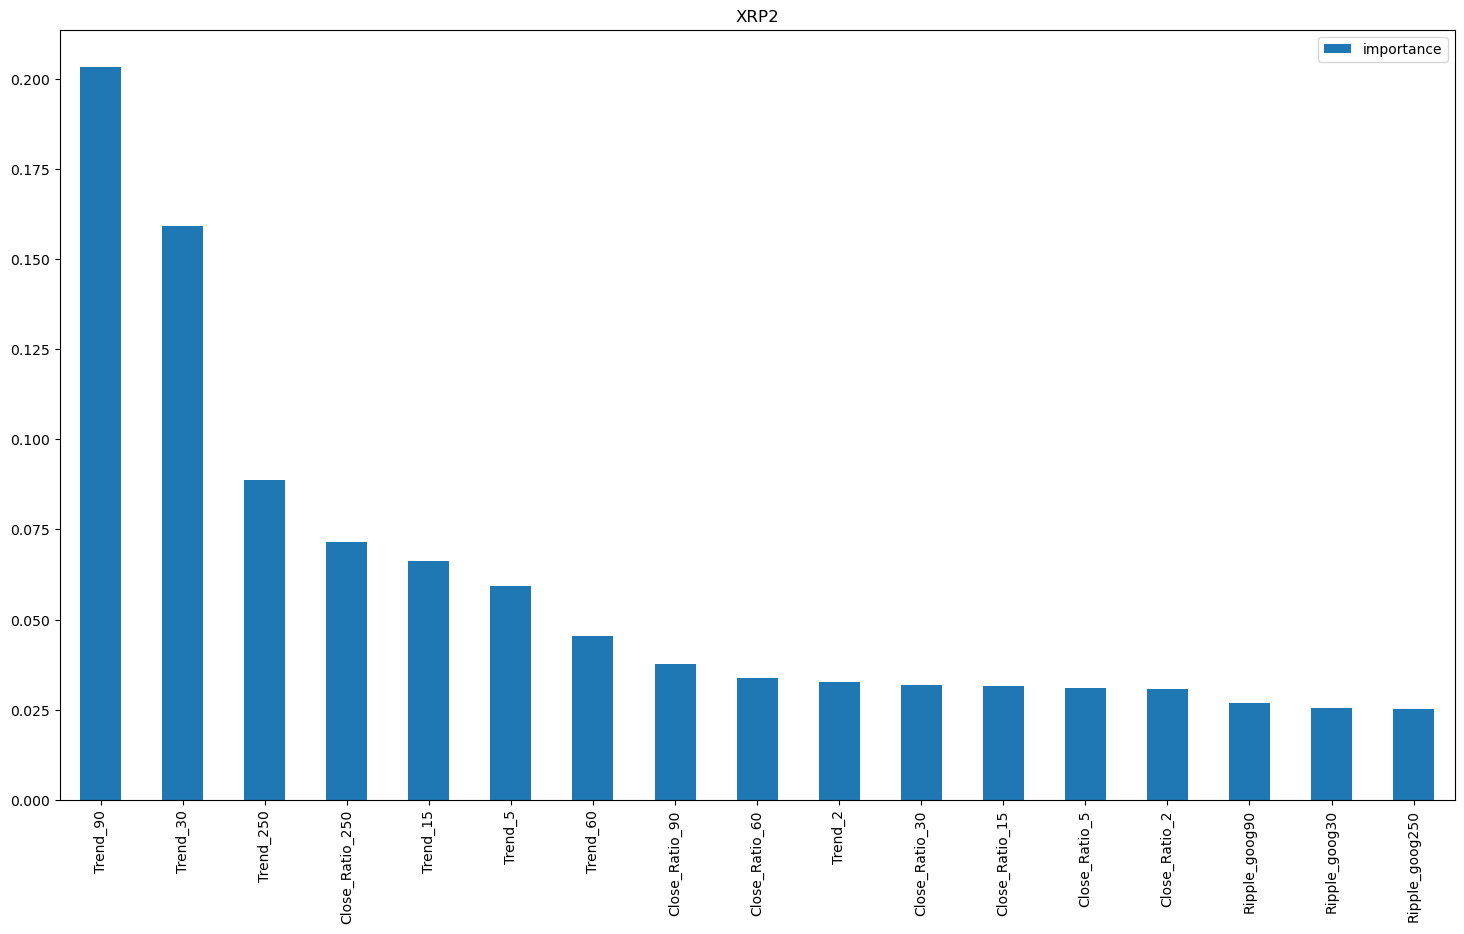

In [26]:
horizons=[2,5,15,30,60,90,250]
precision_list, predictors = generate_all_xgbmodels(df_org, tickers, horizons=horizons, save=True, remove=['month','stoch_k','day_of_week','day_of_month'], use_inflations=False)

'bad precision:'

,precision
ETH2,0.4886
XRP2,0.4670


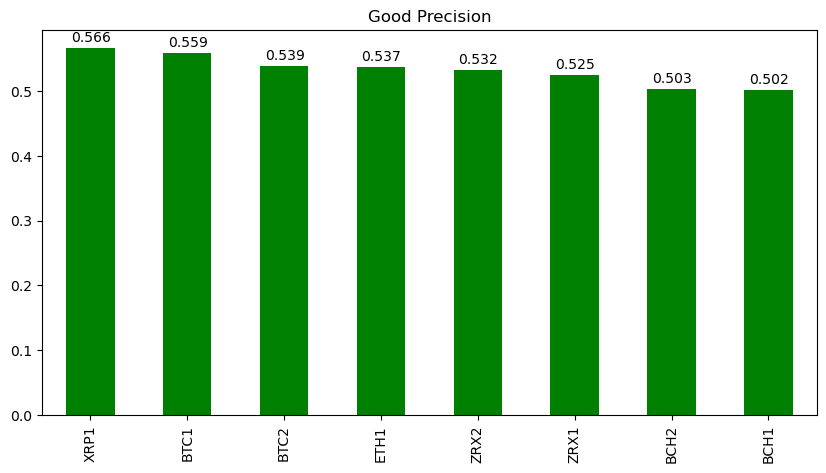

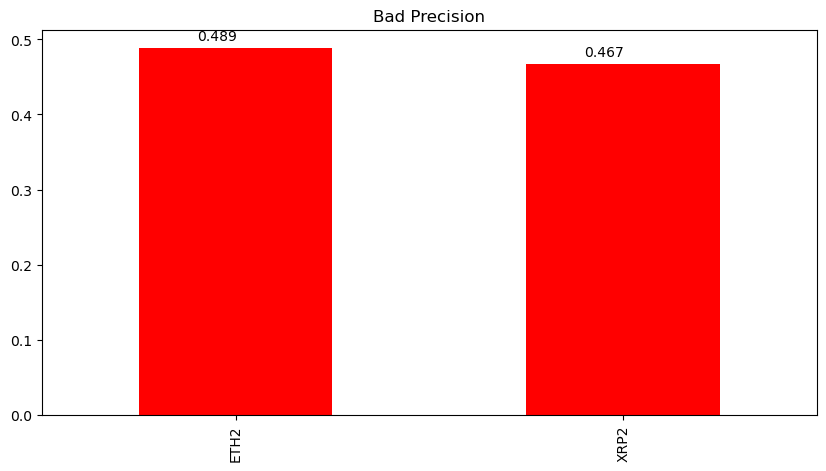

In [27]:

df_precision = pd.DataFrame(dict(precision_list), index=['precision']).T
df_precision.query('precision > 0.5').sort_values(by='precision',ascending=False).plot(kind='bar', figsize=(10,5), title = 'Good Precision', color='green', legend=False)
# plot values in bars
for i, v in enumerate(df_precision.query('precision > 0.5').sort_values(by='precision',ascending=False).values):
    plt.text(i-0.2, v+0.01, str(round(v[0],3)))
try:
    df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False).plot(kind='bar',  figsize=(10,5), title='Bad Precision',color='red', legend=False)
    # plot values in bars
    for i, v in enumerate(df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False).values):
        plt.text(i-0.1, v+0.01, str(round(v[0],3)))
except IndexError:
    print('No bad precision!')

display('bad precision:',df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False))
df_precision.to_csv('precision_lags_and_ratio_no_month_stochk_15_90.csv')
# df

In [28]:
# sort the list
precision_list.sort(key=lambda x: x[1], reverse=True)
precision_list
df_precision

,precision
BTC1,0.5592
BTC2,0.5391
ETH1,0.5374
ETH2,0.4886
BCH1,0.5017
BCH2,0.5025
ZRX1,0.5248
ZRX2,0.5319
XRP1,0.5660
XRP2,0.4670


Figure(1800x1000)


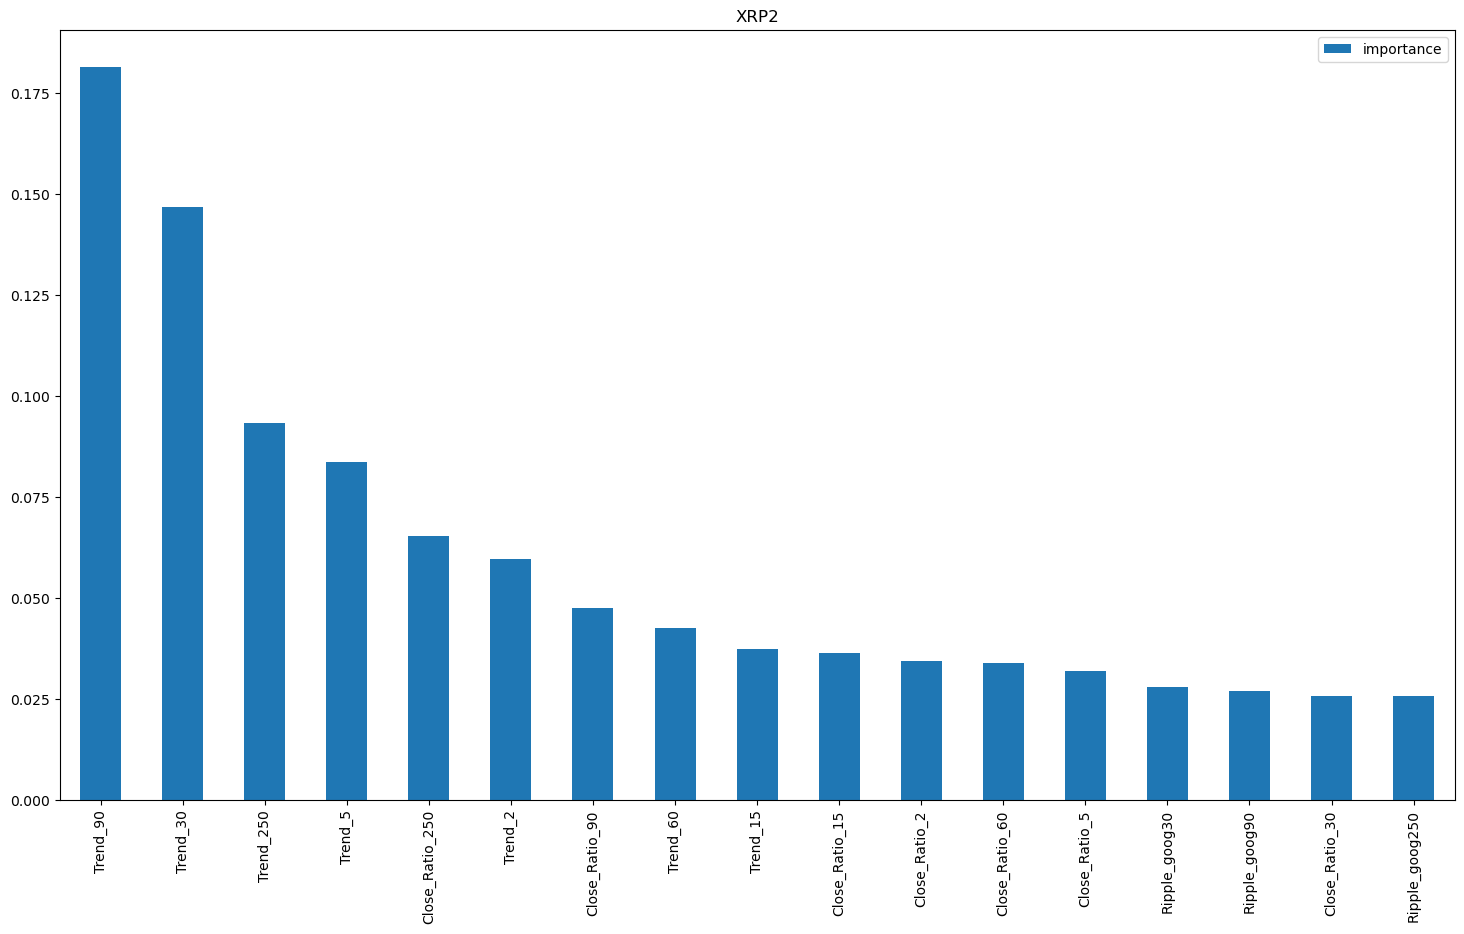

In [29]:
# horizons = [2, 5, 15, 30, 60, 90, 250]
# df, predictors = add_predictors(df_org, tickers[0], 'y1', horizons=horizons)
# df, predictors = add_google_trends(df, df_trend, tickers[0], predictors)
# df['BTC_lag1'] = df['BTC-USD'].shift(1)
# df['BTC_lag_2'] = df['BTC-USD'].shift(2)
# df['ETH_lag_1'] = df['ETH-USD'].shift(1)
# df['ETH_lag_2'] = df['ETH-USD'].shift(2)
# display(predictors)
# df[predictors]
model = xgb.XGBClassifier()
model.load_model('XRP_y2.json')
df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = predictors).sort_values(by = 'importance', ascending = False)
print(df_imp.plot(kind = 'bar', title='XRP'+'2', figsize = (18, 10)).get_figure())
plt.show()
        

Kollar TimeSeriesSplit Cross Validation  
Jag gillar min egen backtest-variant bätte   
- Den har start vilket garanterar att första Train-datat inte är för litet  
- Den har step-size i stället för n_splits vilka ger samma index-värden om så önskas  
- Båda har gap 

In [30]:
horizons=[2,5,15,30,60,90,250]
df, predictors = add_predictors(df_org, tickers[0], 'y1', horizons=horizons)
df, predictors = add_google_trends(df, df_trend, tickers[0], predictors)

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10,gap=1)
for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index[0], '-', train_index[-1], "\nTEST:", test_index[0], '-', test_index[-1])
    # X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    # y_train, y_test = df.iloc[train_index], df.iloc[test_index]


TRAIN: 0 - 283 
TEST: 285 - 563
TRAIN: 0 - 562 
TEST: 564 - 842
TRAIN: 0 - 841 
TEST: 843 - 1121
TRAIN: 0 - 1120 
TEST: 1122 - 1400
TRAIN: 0 - 1399 
TEST: 1401 - 1679
TRAIN: 0 - 1678 
TEST: 1680 - 1958
TRAIN: 0 - 1957 
TEST: 1959 - 2237
TRAIN: 0 - 2236 
TEST: 2238 - 2516
TRAIN: 0 - 2515 
TEST: 2517 - 2795
TRAIN: 0 - 2794 
TEST: 2796 - 3074


### Test plotly

In [31]:
df.columns

Index(['BTC-USD', 'ETH-USD', 'BCH-USD', 'ZRX-USD', 'XRP-USD', 'stoch_k', 'Tomorrow', 'After_tomorrow', 'y1', 'y2', 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_15',
       'Trend_15', 'Close_Ratio_30', 'Trend_30', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_90', 'Trend_90', 'Close_Ratio_250', 'Trend_250', 'day_of_month', 'day_of_week', 'month', 'Bitcoin_goog30',
       'Bitcoin_goog90', 'Bitcoin_goog250'],
      dtype='object')

In [32]:
df[['BTC-USD', 'ETH-USD', 'BCH-USD', 'ZRX-USD', 'XRP-USD','Tomorrow','After_tomorrow', 'Trend_2', 'Trend_5', 'Close_Ratio_2']]

,BTC-USD,ETH-USD,BCH-USD,ZRX-USD,XRP-USD,Tomorrow,After_tomorrow,Trend_2,Trend_5,Close_Ratio_2
Date,,,,,,,,,,
2014-09-17,457.3340,NaN,NaN,NaN,NaN,424.4400,394.7960,NaN,NaN,1.0000
2014-09-18,424.4400,NaN,NaN,NaN,NaN,394.7960,408.9040,424.4400,424.4400,0.9627
2014-09-19,394.7960,NaN,NaN,NaN,NaN,408.9040,398.8210,409.6180,409.6180,0.9638
2014-09-20,408.9040,NaN,NaN,NaN,NaN,398.8210,402.1520,401.8500,409.3800,1.0176
2014-09-21,398.8210,NaN,NaN,NaN,NaN,402.1520,435.7910,403.8625,406.7402,0.9875
...,...,...,...,...,...,...,...,...,...,...
2023-02-12,21788.2031,1515.0337,122.9004,0.2339,0.3753,21808.1016,22220.8047,21829.5391,22013.7398,0.9981
2023-02-13,21808.1016,1507.1659,123.8580,0.2242,0.3717,22220.8047,24307.8418,21798.1523,21787.4805,1.0005
2023-02-14,22220.8047,1556.8751,126.7319,0.2325,0.3824,24307.8418,24587.9258,22014.4531,21867.8336,1.0094


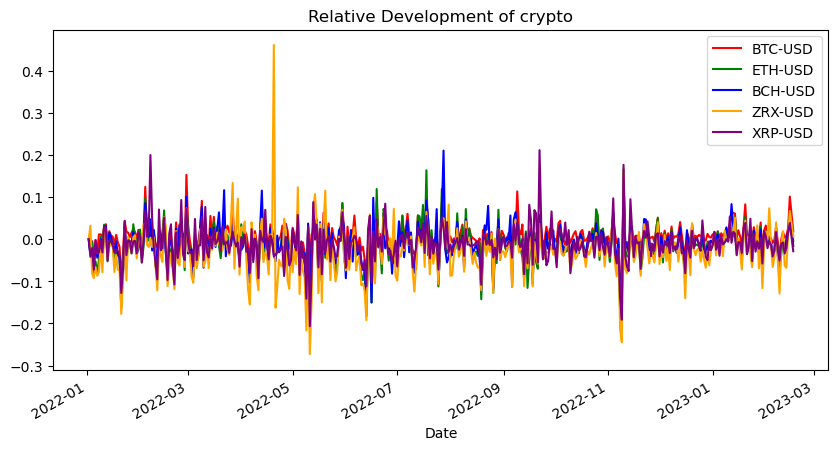

,BTC-USD,ETH-USD,BCH-USD,ZRX-USD,XRP-USD
Date,,,,,
2022-01-02,0.0000,0.0000,0.0000,0.0000,0.0000
2022-01-03,-0.0116,-0.0337,-0.0364,0.0319,-0.0419
2022-01-04,-0.0049,-0.0072,-0.0247,-0.0815,-0.0212
2022-01-05,-0.0436,-0.0801,-0.0683,-0.0923,-0.0724
2022-01-06,-0.0022,-0.0531,-0.0099,-0.0662,-0.0023
...,...,...,...,...,...
2023-02-12,0.0034,-0.0320,-0.0225,-0.0624,-0.0341
2023-02-13,0.0081,-0.0211,0.0002,-0.0680,-0.0210
2023-02-14,0.0261,0.0171,0.0156,0.0104,0.0175


In [33]:
# compute relative development
def rel_dev(df_ticker_):
    df_ticker = df_ticker_.copy()
    df_ticker = df_ticker/df_ticker.shift(1)-1
    df_ticker = df_ticker.dropna()
    just = df_ticker.head(1).values[0]
    df_ticker -= just
    return df_ticker

BTC = df[['BTC-USD']].query('index >= "2022-01-01"'); ETH = df[['ETH-USD']].query('index >= "2022-01-01"'); BCH = df[['BCH-USD']].query('index >= "2022-01-01"'); ZRX = df[['ZRX-USD']].query('index >= "2022-01-01"'); XRP = df[['XRP-USD']].query('index >= "2022-01-01"')

BTC = rel_dev(BTC)
ETH = rel_dev(ETH)
BCH = rel_dev(BCH)
ZRX = rel_dev(ZRX)
XRP = rel_dev(XRP)
# share x-axis

comb = pd.concat([BTC,ETH,BCH,ZRX,XRP],axis=1,)
# plot comb
comb.plot(figsize=(10,5), title='Relative Development of crypto', color=['red','green','blue','orange','purple'])
# share the same x-axis
plt.show()
display(comb)

In [34]:
import plotly.express as px

# make aa plotly line chart with two lines

fig = px.line(comb, x=comb.index, y=[
              'BTC-USD', 'ETH-USD', 'BCH-USD', 'ZRX-USD', 'XRP-USD'], title='Price')
# make fig higher and more narrow
fig.update_layout(height=800, width=1000)
# thicker lines
fig.update_traces(line=dict(width=2))

fig.show()